# Análise de dados e construção de modelo de machine learning para análise de fake news


- importando libs para análise de dados

In [1]:
import pandas as pd
import numpy as np
from unidecode import unidecode
import re
import collections
import nltk
import time

## Importando o arquivo com todas as notícias

In [2]:
todas_noticias = pd.read_csv('todos_os_dados.csv')
todas_noticias.target.unique()

array(['falso', 'verdadeiro'], dtype=object)

## Limpeza dos dados (Feature engineering)

- Para esta análise de dados não precisaremos do link da imagem nem da origem da notícia
- Vamos trabalhar apenas com a coluna `info` e a coluna `target`

In [3]:
todas_noticias = todas_noticias[['info', 'target']]
todas_noticias.sample(5)

,info,target
5113,"Desemprego fica em 12% e atinge 12,6 milhões d...",verdadeiro
10580,“[A] Universidade Federal de Sergipe [tem]: 30...,verdadeiro
5645,Defesa de Lula pede ao STJ para impedir prisão...,verdadeiro
3684,"Após decisão do STF, goleiro Bruno se apresent...",verdadeiro
7655,"\nGente, cuidado com o pimentão. Esse verme ch...",falso


**Renomeando:** Serão renomeadas o nome das colunas para português, estamos trabalhando com dados em português e o código também segue o padrão português, também para facilitar o entendimento de quem irá consumir este notebook

In [4]:
colunas = {'info': 'texto', 'target': 'classificacao'}
todas_noticias.rename(columns=colunas, inplace=True)

In [5]:
len(todas_noticias[todas_noticias.classificacao == 'verdadeiro'])

5014

In [6]:
len(todas_noticias[todas_noticias.classificacao == 'falso'])

7497

In [7]:
len(todas_noticias)

12511

- Verificar se existem dados vazios ou inválidos nas colunas info e target

In [8]:
num_texto_null = len(todas_noticias[todas_noticias['texto'].isnull()])
num_texto_vazio = len(todas_noticias[todas_noticias['texto'].isna()])
assert  num_texto_null + num_texto_vazio == 0

In [9]:
num_classificacao_null = len(todas_noticias[todas_noticias['classificacao'].isnull()]) 
num_classificacao_vazio = len(todas_noticias[todas_noticias['classificacao'].isna()])
assert num_classificacao_vazio + num_classificacao_null == 0

### Normalizando os dados

- Passar todos os dados para lowercase para que não haja distinção entre maíusculo e minúsculo
- Remover acentuação, aspas e possíveis caracteres especiais

In [10]:
todas_noticias.texto = todas_noticias.texto.map(lambda x: x.lower())

### Removendo acentuação 

- usando a lib `unidecode` remove a acentuação das palavras

In [11]:
todas_noticias.texto = todas_noticias.texto.map(lambda x: unidecode(x))

### Removendo caracteres especiais

- Expressões regulares podem ser usadas para remover caracteres especiais


In [12]:
todas_noticias.texto = todas_noticias.texto.map(lambda x: re.sub('[\W_0-9]+', ' ', x))

## Contando as palavaras

- Montando um contador geral 
- Montando um contador de palavras comuns para fake news
- Montando um contador de palavras comuns para notícias verdadeiras


In [13]:
verdadeiro_count = collections.Counter()
falso_count = collections.Counter()
todas_count = collections.Counter()

In [14]:
def contagem(contador_por_classe, noticia):
    for palavra in noticia:
        print(palavra)
        contador_por_classe.update(palavra)
        todas_count.update(palavra)
    return contador_por_classe
    

In [15]:
for index, row in todas_noticias.iterrows():
    noticia = row['texto'].split(' ')
    if row['classificacao'] == 'verdadeiro':
        verdadeiro_count.update(noticia)
    else:
        falso_count.update(noticia)
    todas_count.update(noticia)

In [16]:
razao_falso_verdadeira = collections.Counter()

In [17]:
for word, count in list(todas_count.most_common()):
    if count > 10:
        razao = verdadeiro_count[word] / float(falso_count[word] + 1)
        razao_falso_verdadeira[word] = razao

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/willian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
verdadeiro_count_plot = verdadeiro_count.copy()
falso_count_plot = falso_count.copy()

In [20]:
stopwords = nltk.corpus.stopwords.words('portuguese')

In [21]:
palavras_comuns = [unidecode(palavra) for palavra in stopwords]

In [22]:
for palavra in palavras_comuns:
    if palavra in list(falso_count):
        del falso_count[palavra]
    if palavra in list(verdadeiro_count):
        del verdadeiro_count[palavra]   

In [23]:
vocabulario = set(todas_count.keys())   

In [24]:
len(vocabulario)

82080

In [25]:
len(todas_noticias)

12511

## Visualização de dados

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
import seaborn as sns

In [28]:
df_most_commom = pd.DataFrame(todas_count.most_common(), columns=['word', 'count'])

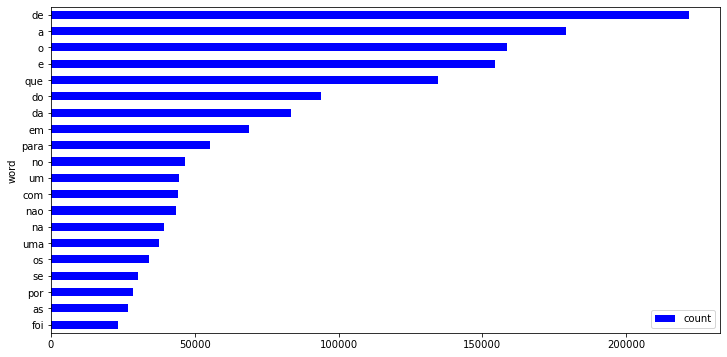

In [29]:
## top mais comuns
df_most_commom[:20].plot.barh(x='word', y='count', color='blue').invert_yaxis()
plt.gcf().set_size_inches(12,6)
plt.rcParams.update({'font.size': 22})

In [30]:
df_all = pd.DataFrame.from_dict(todas_count, orient='index').reset_index()
df_all.head()
df_all.rename(columns={'index':'word', 0:'count'}, inplace=True)

In [31]:
df_verdadeiro_count = pd.DataFrame(verdadeiro_count_plot.most_common(),columns=['word','count'])
df_verdadeiro_count.head()

,word,count
0,de,188352
1,a,152951
2,o,131554
3,e,130153
4,que,113356


In [32]:
df_falso_count = pd.DataFrame(falso_count_plot.most_common(), columns=['word', 'count'])
df_falso_count.head()

,word,count
0,de,33284
1,o,26878
2,a,25957
3,e,24097
4,que,21153


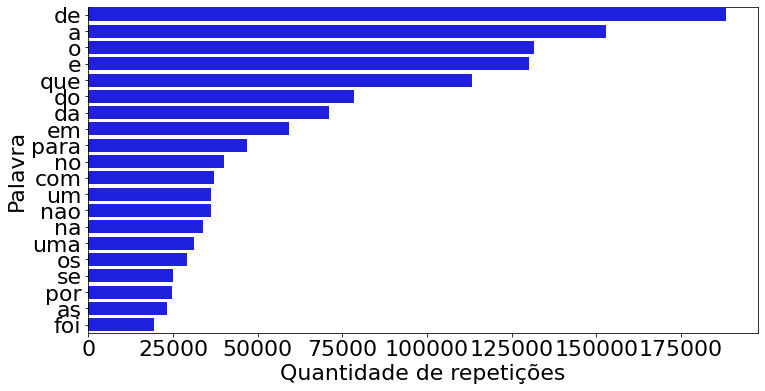

In [33]:
ax = sns.barplot(y='word', x='count', data=df_verdadeiro_count[:20],  color = 'blue')
plt.gcf().set_size_inches(12,6)
plt.rcParams.update({'font.size': 22})
ax.set(xlabel='Quantidade de repetições', ylabel='Palavra')
plt.show()

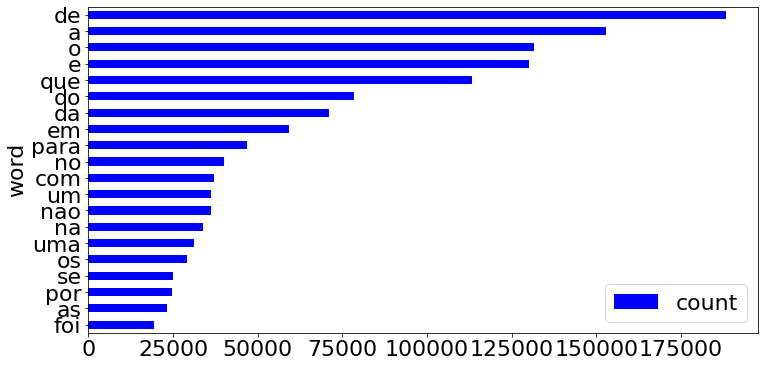

In [34]:
df_verdadeiro_count[:20].plot.barh(x='word', y='count', color='blue').invert_yaxis()
plt.gcf().set_size_inches(12,6)
plt.rcParams.update({'font.size': 20})

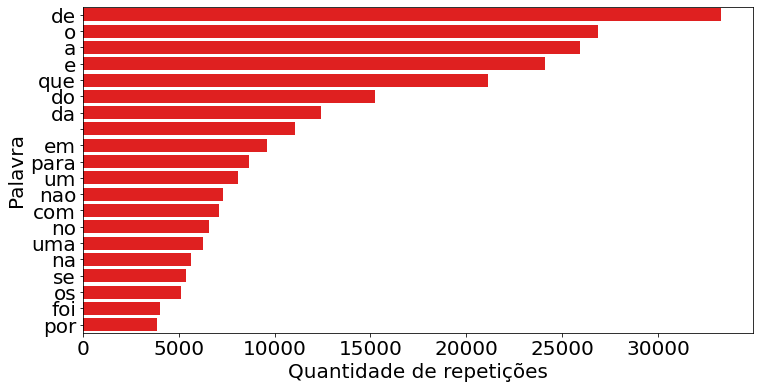

In [35]:
ax = sns.barplot(y='word', x='count', data=df_falso_count[:20], color='red')
plt.gcf().set_size_inches(12,6)
ax.set(xlabel='Quantidade de repetições', ylabel='Palavra')
plt.rcParams.update({'font.size': 22})

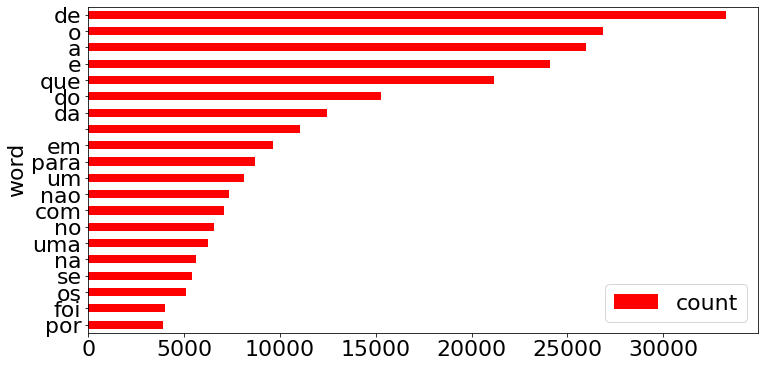

In [36]:
df_falso_count[:20].plot.barh(x='word', y='count', color='red').invert_yaxis()
plt.gcf().set_size_inches(12,6)


In [37]:
df_verdadeiro_mc_whithout_sw = pd.DataFrame(verdadeiro_count.most_common(), columns=['word', 'count'])
df_falso_mc_whithout_sw = pd.DataFrame(falso_count.most_common(), columns=['word', 'count'])

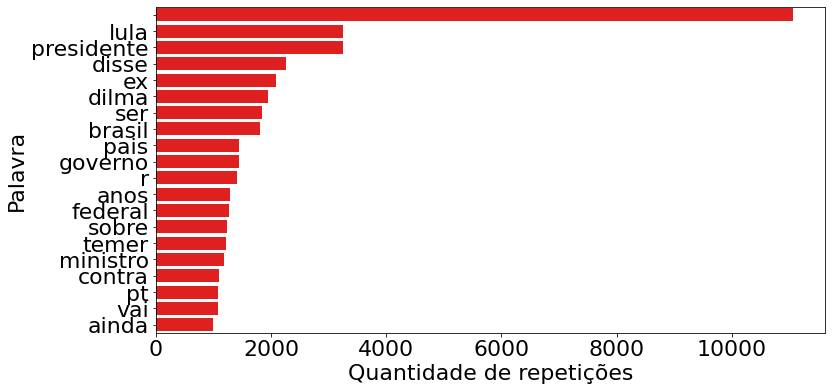

In [111]:
ax = sns.barplot(y='word', x='count', data=df_falso_mc_whithout_sw[:20], color='red')
plt.gcf().set_size_inches(12,6)
ax.set(xlabel='Quantidade de repetições', ylabel='Palavra')
plt.rcParams.update({'font.size': 22})

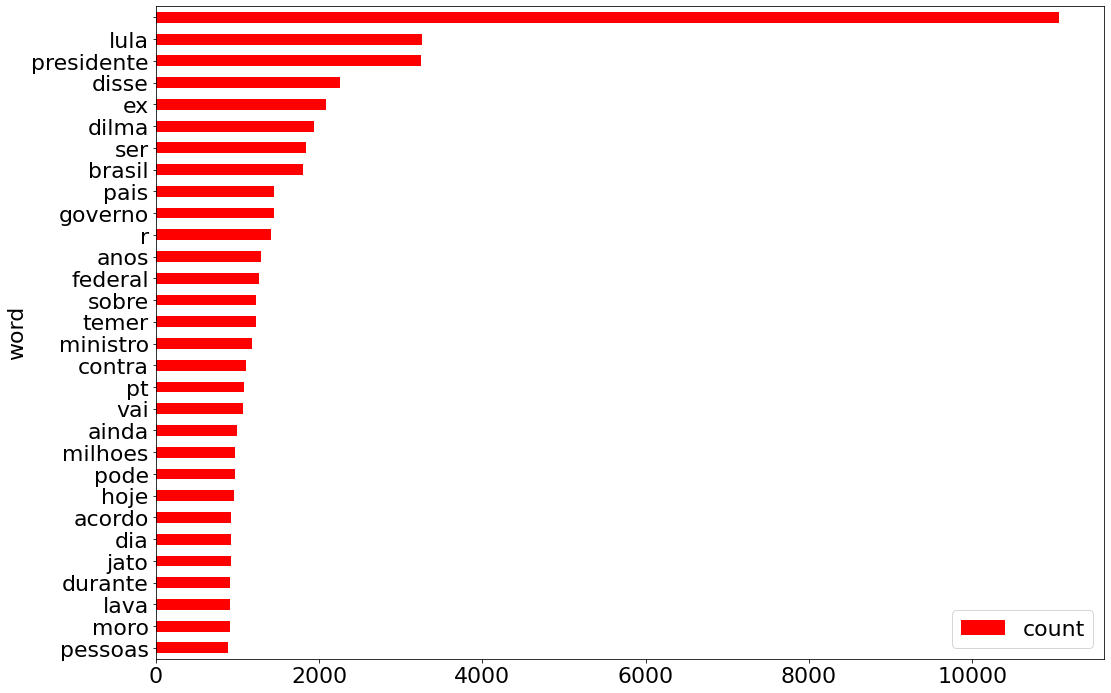

In [38]:
df_falso_mc_whithout_sw.sort_values(by='count', ascending=False)
df_falso_mc_whithout_sw[:30].plot.barh(x='word', y='count', color='red').invert_yaxis()
plt.gcf().set_size_inches(17,12)
plt.rcParams.update({'font.size': 22})

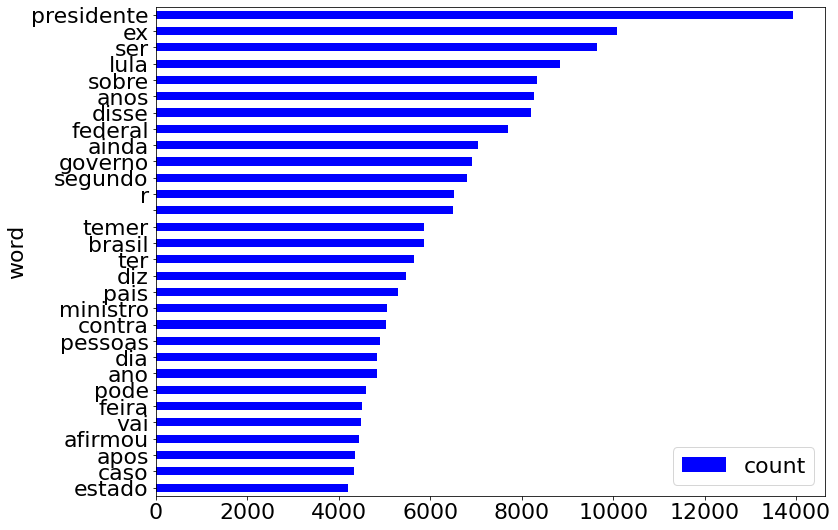

In [39]:
df_verdadeiro_mc_whithout_sw.sort_values(by='count', ascending=False)
df_verdadeiro_mc_whithout_sw[:30].plot.barh(x='word', y='count', color='blue').invert_yaxis()
plt.gcf().set_size_inches(12,9)
plt.rcParams.update({'font.size': 20})

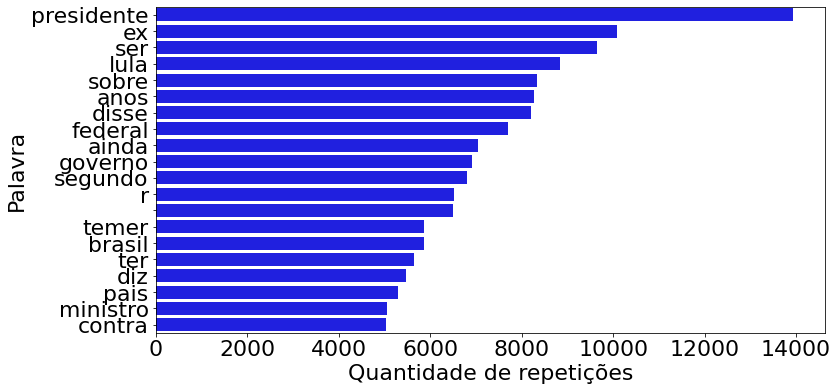

In [109]:
ax = sns.barplot(y='word', x='count', data=df_verdadeiro_mc_whithout_sw[:20], color='blue')
plt.gcf().set_size_inches(12,6)
ax.set(xlabel='Quantidade de repetições', ylabel='Palavra')
plt.rcParams.update({'font.size': 22})

In [40]:
from wordcloud import WordCloud, ImageColorGenerator

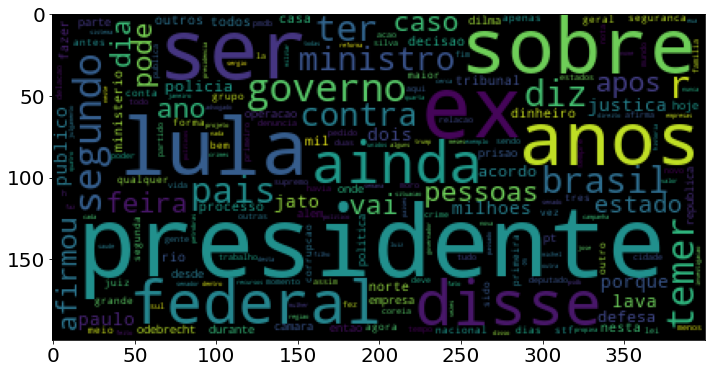

In [41]:
verdadeiro_cloud = WordCloud(stopwords=stopwords).generate_from_frequencies(verdadeiro_count)

plt.imshow(verdadeiro_cloud)
plt.gcf().set_size_inches(12,6)
plt.rcParams.update({'font.size': 22})

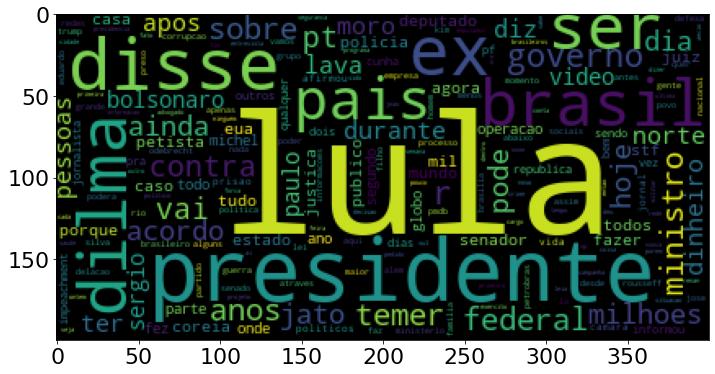

In [42]:
falso_count_cloud = WordCloud(stopwords=stopwords).generate_from_frequencies(falso_count)

plt.imshow(falso_count_cloud)
plt.gcf().set_size_inches(12,6)
plt.rcParams.update({'font.size': 22})

In [43]:
#Quantidade total de noticias
total = len(todas_noticias)
total

12511

In [44]:
#total de falsas
total_falsas = len(todas_noticias[todas_noticias.classificacao == 'falso'])
total_falsas

7497

In [45]:
#total de verdadeiras
total_verdadeiras = len(todas_noticias[todas_noticias.classificacao == 'verdadeiro'])
total_verdadeiras

5014

In [46]:
#Porcentagem falsa
porcentagem_falsa = total_falsas / total * 100
porcentagem_verdadeira = total_verdadeiras / total * 100

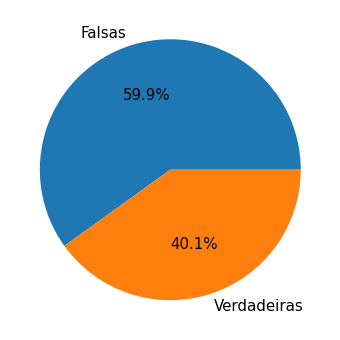

In [100]:
fatias = [porcentagem_falsa, porcentagem_verdadeira]
labels = ['Falsas', 'Verdadeiras']
fig1 = plt.subplot()
ax = fig1.pie(fatias, labels=labels, autopct='%1.1f%%')
plt.gcf().set_size_inches(12,6)
plt.rcParams.update({'font.size': 22})

plt.show()


In [48]:
## Media
falsas = todas_noticias[todas_noticias.classificacao == 'falso']
somatorio_falsas = falsas.texto.map(lambda x: len(x))
somatorio_falsas.mean()

584.8991596638656

In [49]:
## Media
verdadeiras = todas_noticias[todas_noticias.classificacao == 'verdadeiro']
somatorio_verdadeiras = verdadeiras.texto.map(lambda x: len(x))
somatorio_verdadeiras.mean()

4635.04128440367

In [50]:
#Mediana
somatorio_falsas.median()

300.0

In [51]:
#Mediana
somatorio_verdadeiras.median()

4026.0

In [52]:
#Moda
somatorio_falsas.mode()

0    79
dtype: int64

In [53]:
#Moda
somatorio_verdadeiras.mode()

0    69
dtype: int64

In [54]:
np.seterr(divide = 'ignore') 
razao_falso_verdadeira_log = {k: np.log(v) for k, v in razao_falso_verdadeira.items()}

In [55]:
s  = pd.Series(razao_falso_verdadeira_log,index=razao_falso_verdadeira_log.keys()).to_frame()
s.rename(columns = {0: 'razao'}, inplace=True)
s.head()

s.replace([np.inf, -np.inf], np.nan, inplace=True)
s.dropna(inplace=True)
s['razao'] = s['razao'].map(lambda x: np.float(x))


<ipython-input-55-418eeb3aee71>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  s['razao'] = s['razao'].map(lambda x: np.float(x))


In [56]:
hist_counter = collections.Counter(s.to_dict())

In [57]:
razao_range = np.arange(min(s['razao']), max(s['razao']), 0.2)

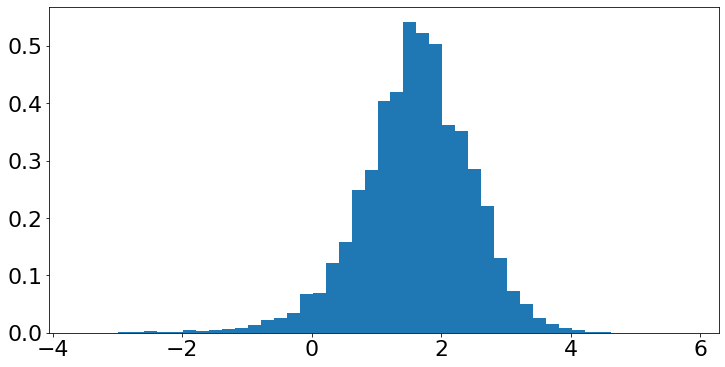

In [58]:
hist = plt.hist(s['razao'],density=True,bins=razao_range)
plt.gcf().set_size_inches(12,6)
plt.rcParams.update({'font.size': 22})
plt.show()


/home/willian/anaconda3/envs/tcc/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'Razão'), Text(0, 0.5, 'Densidade')]

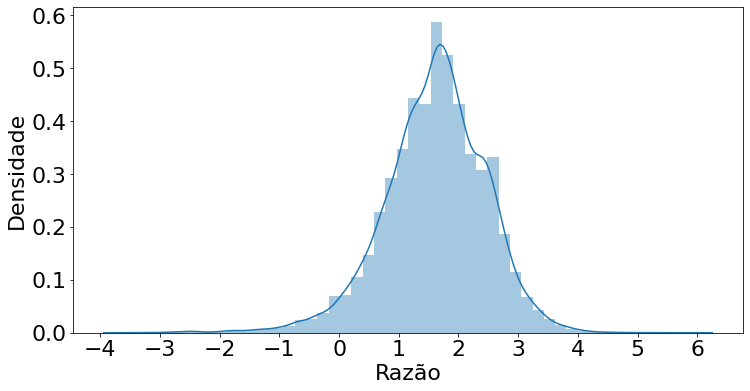

In [126]:
raz = sns.distplot(s['razao'])
plt.gcf().set_size_inches(12,6)
plt.rcParams.update({'font.size': 22})
raz.figure.set_size_inches(12,6)
raz.set_xticks(range(-4,7))
raz.set(xlabel='Razão', ylabel='Densidade')

In [60]:
verdadeiras = []
for nome, cont in verdadeiro_count.items():
    if nome in razao_falso_verdadeira_log.keys():
        ratio = razao_falso_verdadeira_log[nome]
        if not np.isinf(ratio):
            verdadeiras.append({'palavra':nome, 'cont': cont, 'ratio': ratio})
verdadeiras = pd.DataFrame(verdadeiras)
verdadeiras.sample(5)
min(verdadeiras['ratio'])

-3.58351893845611

In [61]:
falsas = []
for nome, cont in falso_count.items():
    if nome in razao_falso_verdadeira_log.keys():
        ratio = razao_falso_verdadeira_log[nome]
        if not np.isinf(ratio):
            falsas.append({'palavra':nome, 'cont': cont, 'ratio': ratio})
falsas = pd.DataFrame(falsas)

falsas.sample(5)


,palavra,cont,ratio
2403,irreversivel,11,0.650588
10520,roubando,7,0.810930
946,alienacao,1,1.704748
16908,ativar,1,1.791759
3638,jereissati,6,2.061423


In [127]:
data_ratio = pd.DataFrame.from_dict(razao_falso_verdadeira_log, orient='index').reset_index()

data_ratio.rename(columns={'index':'word', 0:'ratio'}, inplace=True)
data_ratio.head(10)

,word,ratio
0,de,1.733206
1,a,1.773638
2,o,1.588072
3,e,1.686582
4,que,1.678704
5,do,1.639177
6,da,1.744373
7,em,1.816634
8,para,1.683674
9,no,1.809666


In [63]:
stop = []
for nome in stopwords:
    if nome in razao_falso_verdadeira_log.keys():
        ratio = razao_falso_verdadeira_log[nome]
        cont = todas_count[nome]
        if not np.isinf(ratio):
            stop.append({'palavra':nome, 'cont': cont, 'ratio': ratio})
stop = pd.DataFrame(stop)
stop.sample(5)

,palavra,cont,ratio
96,esteja,287,1.883875
109,era,5944,1.875689
94,estava,3685,1.584897
18,as,26788,1.864671
17,mais,18592,1.596649


In [64]:
stop_df = []
for nome in stopwords:
    if nome in razao_falso_verdadeira_log.keys():
        ratio = razao_falso_verdadeira_log[nome]
        cont = todas_count[nome]
        if not np.isinf(ratio):
            stop_df.append({'palavra':nome, 'count': cont, 'ratio': ratio, 'classe':'Neutro'})
stop_df = pd.DataFrame(stop_df)
stop_df.sample(5)

,palavra,count,ratio,classe
30,nos,9506,1.794462,Neutro
136,tenha,1195,2.045099,Neutro
102,estiverem,35,0.451985,Neutro
146,teria,2283,1.165106,Neutro
60,esses,1267,1.723510,Neutro


In [65]:
stop_df.rename(columns={'palavra':'word', 'cont':'count'}, inplace=True)

In [66]:
falsas['classe'] = 'Flaso'

In [67]:
falsas.rename(columns={'palavra': 'word', 'cont': 'count'}, inplace=True)

In [68]:
verdadeiras['classe'] = 'Verdadeiro'

In [69]:
verdadeiras.rename(columns={'palavra': 'word', 'cont': 'count'}, inplace=True)

In [70]:
all_count_ratio = pd.concat([stop_df, verdadeiras, falsas])

In [71]:
all_count_ratio.head()

,word,count,ratio,classe
0,de,221636,1.733206,Neutro
1,a,178908,1.773638,Neutro
2,o,158432,1.588072,Neutro
3,que,134509,1.678704,Neutro
4,e,154250,1.686582,Neutro


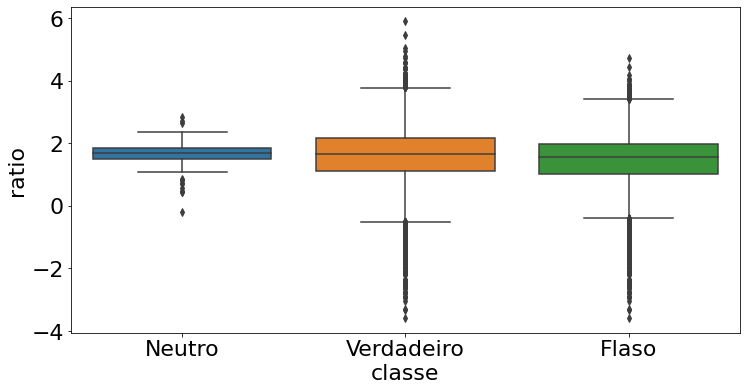

In [72]:
ax = sns.boxplot(x='classe', y='ratio', data=all_count_ratio)
ax.figure.set_size_inches(12,6)
plt.rcParams.update({'font.size': 22})

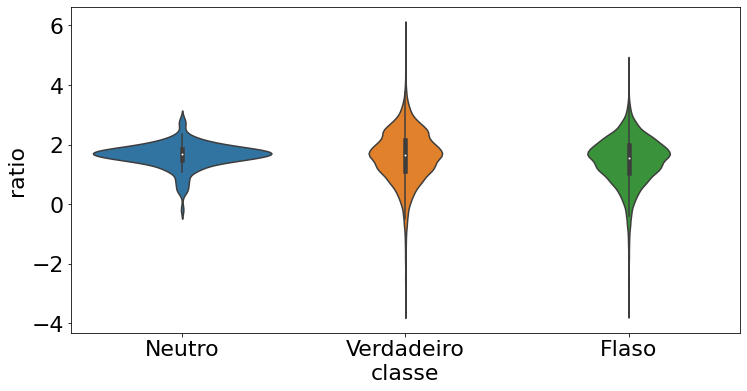

In [73]:
ax = sns.violinplot(x='classe', y='ratio', data=all_count_ratio)
ax.figure.set_size_inches(12,6)
plt.rcParams.update({'font.size': 22})

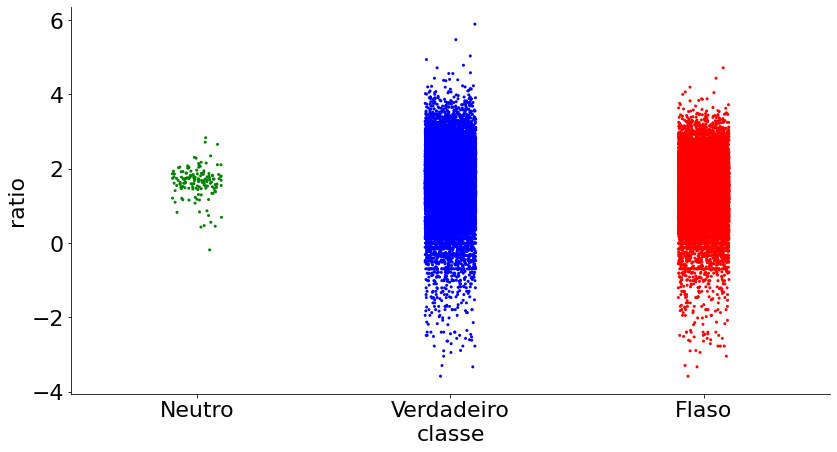

In [74]:
ax = sns.catplot(x='classe',y='ratio', data=all_count_ratio, height=10, s=3,  palette={'Neutro':'g','Verdadeiro':'b','Flaso':'r'})
plt.gcf().set_size_inches(12,6)
plt.rcParams.update({'font.size': 22})

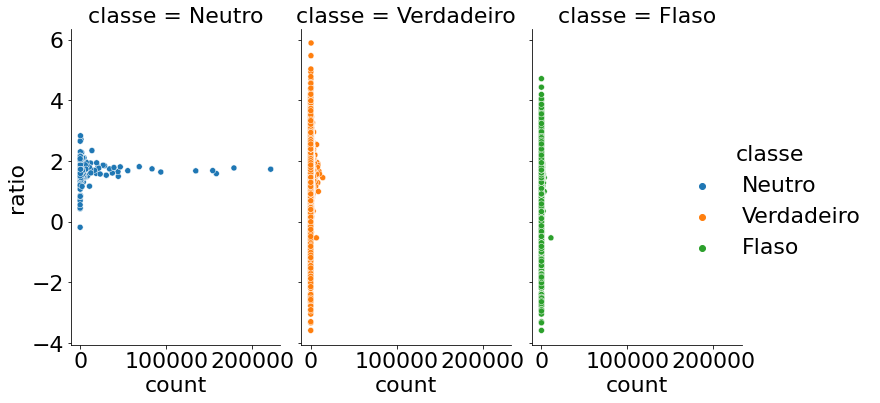

In [75]:
sns.relplot(x='count', y='ratio', hue='classe', col='classe', data=all_count_ratio)
plt.gcf().set_size_inches(12,6)
plt.rcParams.update({'font.size': 20})

In [76]:
len(falsas)

17070

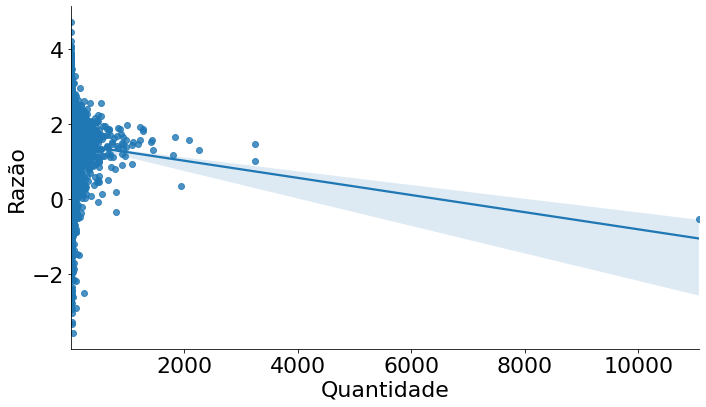

In [130]:
len(falsas)
ax = sns.lmplot(x='count', y='ratio', data=falsas)
ax.set(xlabel='Quantidade', ylabel='Razão')
plt.gcf().set_size_inches(12, 6)
plt.rcParams.update({'font.size': 22})


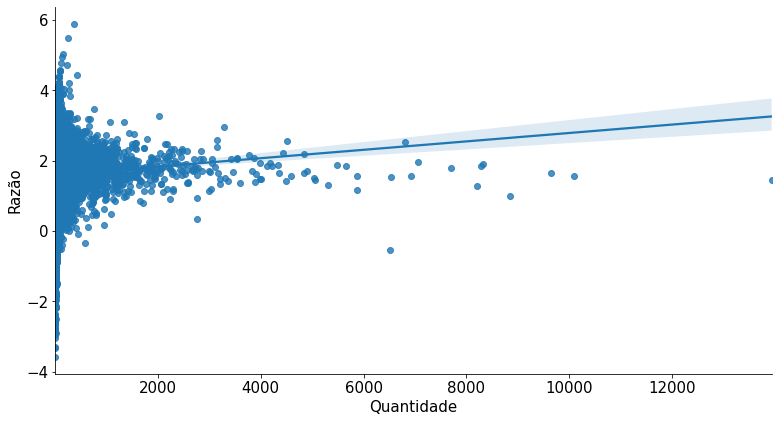

In [133]:
ax = sns.lmplot(x='count', y='ratio', data=verdadeiras)
ax.set(xlabel='Quantidade', ylabel='Razão')
plt.gcf().set_size_inches(12, 6)
plt.rcParams.update({'font.size': 22})

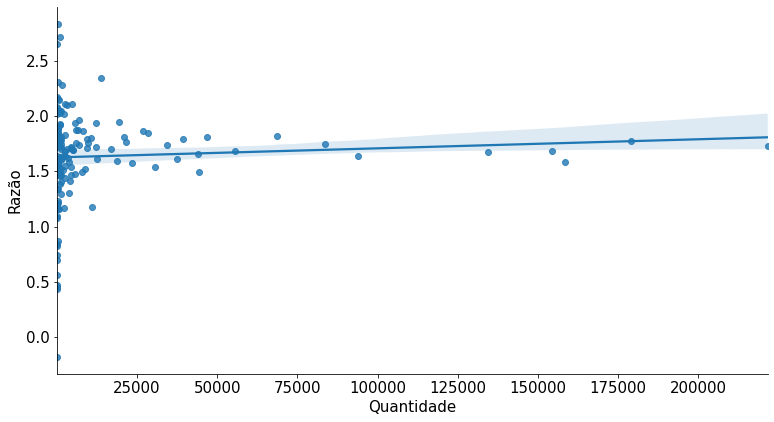

In [135]:
ax = sns.lmplot(x='cont', y='ratio', data=stop)
ax.set(xlabel='Quantidade', ylabel='Razão')
plt.gcf().set_size_inches(12, 6)

plt.rcParams.update({'font.size': 14})

In [81]:
from scipy.stats import ranksums
pvalue = ranksums(falsas['ratio'], verdadeiras['ratio']).pvalue
pvalue

1.2334804991842057e-55

In [82]:
from scipy.stats import ranksums
pvalue_count = ranksums(falsas['count'], verdadeiras['count'])
pvalue_count.pvalue

0.0

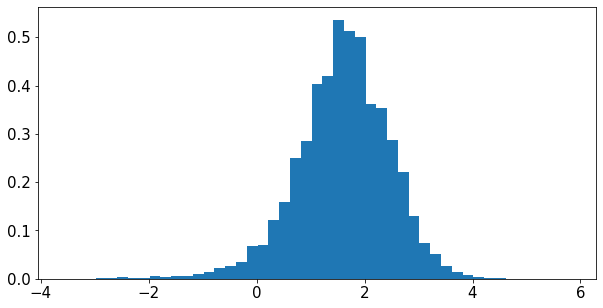

In [83]:
plt.rc('figure', figsize=(10,5))
hist = plt.hist(verdadeiras['ratio'],density=True,bins=razao_range)
plt.show()

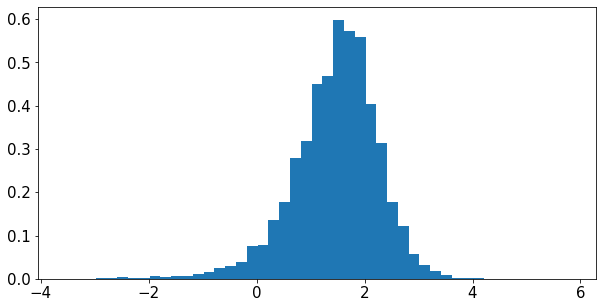

In [84]:
hist = plt.hist(falsas['ratio'],density=True,bins=razao_range)
plt.show()

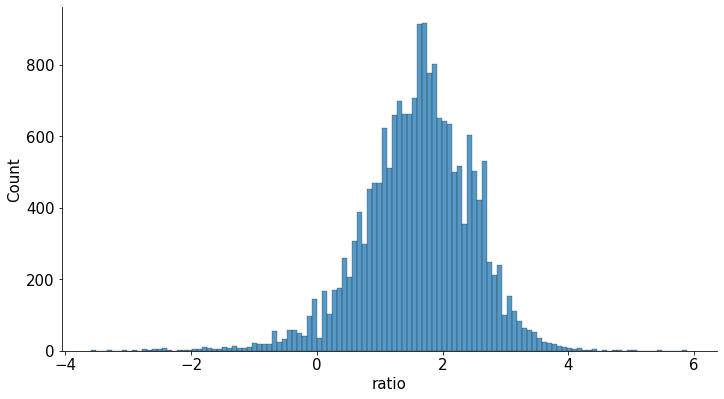

In [85]:
ax = sns.displot(verdadeiras['ratio'])
plt.gcf().set_size_inches(12, 6)

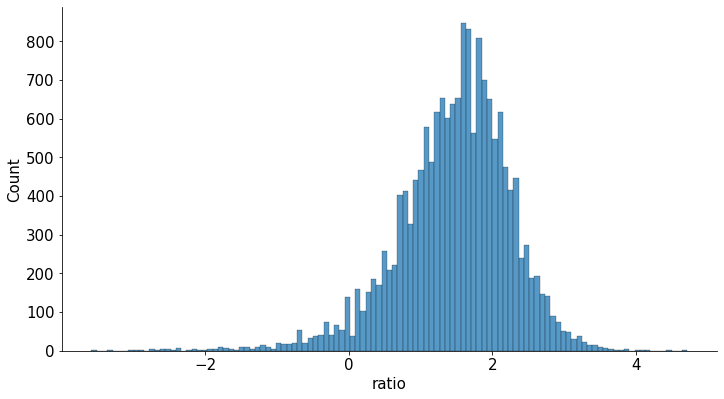

In [86]:
sns.displot(falsas['ratio'])
plt.gcf().set_size_inches(12, 6)

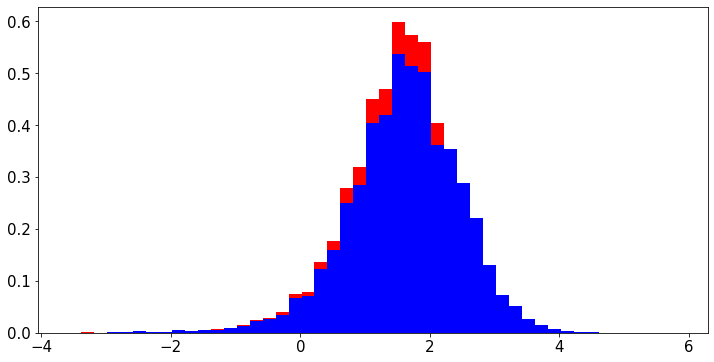

In [87]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)

ax1.hist(falsas['ratio'],density=True,bins=razao_range, color = 'red')
ax1.hist(verdadeiras['ratio'],density=True,bins=razao_range, color = 'blue')
#plt.rc('figure', figsize = (10,10))
plt.show()

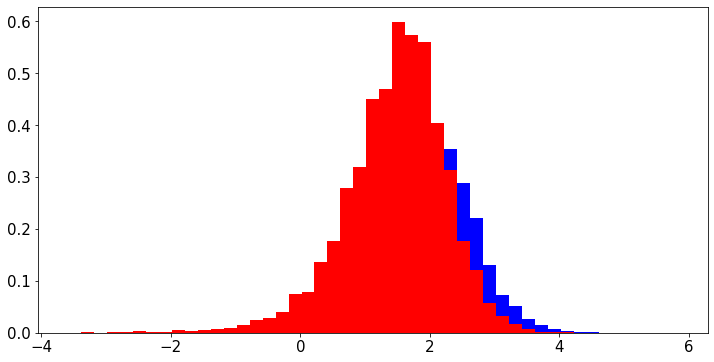

In [88]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)


ax1.hist(verdadeiras['ratio'],density=True,bins=razao_range, color = "blue")
ax1.hist(falsas['ratio'],density=True,bins=razao_range, color = "red")
plt.show()

In [89]:
verdadeiras

,word,count,ratio,classe
0,tse,643,1.442264,Verdadeiro
1,validade,109,2.206441,Verdadeiro
2,depoimentos,619,2.333761,Verdadeiro
3,odebrecht,3053,1.925806,Verdadeiro
4,domina,21,2.351375,Verdadeiro
...,...,...,...,...
19047,coronavirus,5,-2.901422,Verdadeiro
19048,corona,2,-2.602690,Verdadeiro
19049,hidroxicloroquina,1,-3.583519,Verdadeiro
19050,greenwald,1,-2.564949,Verdadeiro


In [90]:
verdadeiras.query('word == "racista"')

,word,count,ratio,classe
11584,racista,41,1.148623,Verdadeiro


In [91]:
falsas.query('word == "racista"')

,word,count,ratio,classe
13768,racista,12,1.148623,Flaso


In [92]:
falso_count['cloroquina']

36

In [93]:
verdadeiro_count['cloroquina']

0

<Figure size 864x432 with 0 Axes>

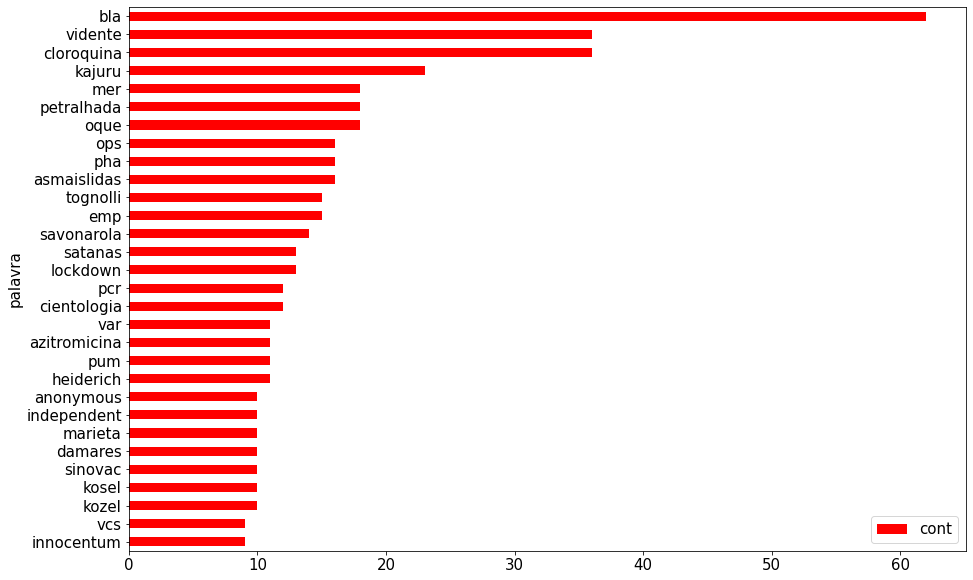

In [96]:
fig = plt.figure(figsize=(12,6))
falso_para_verdadeiro = []
for palavra in falso_count.keys():
    if palavra not in verdadeiro_count.keys():
        falso_para_verdadeiro.append({'palavra': palavra, 'cont': falso_count[palavra]})
falso_para_verdadeiro = pd.DataFrame(falso_para_verdadeiro)
falso_para_verdadeiro.sort_values(by='cont', ascending=False)[0:20]

falso_para_verdadeiro.sort_values(by='cont', ascending=False, inplace=True)
ax = falso_para_verdadeiro[:30].plot.barh(x='palavra', y='cont', color='red').invert_yaxis()
plt.gcf().set_size_inches(15, 10)

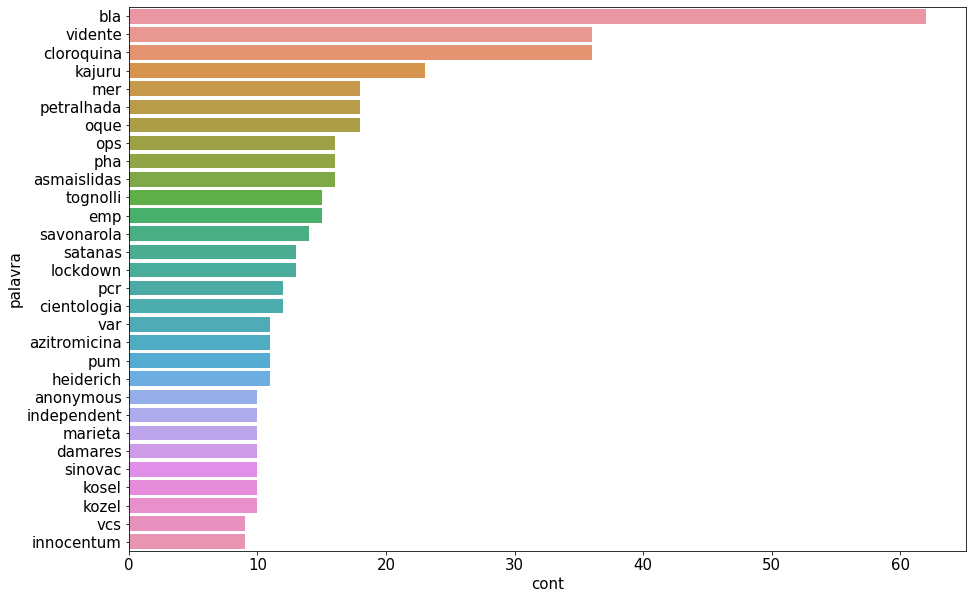

In [97]:
ax = sns.barplot(y='palavra', x='cont', data=falso_para_verdadeiro[:30])
plt.gcf().set_size_inches(15, 10)

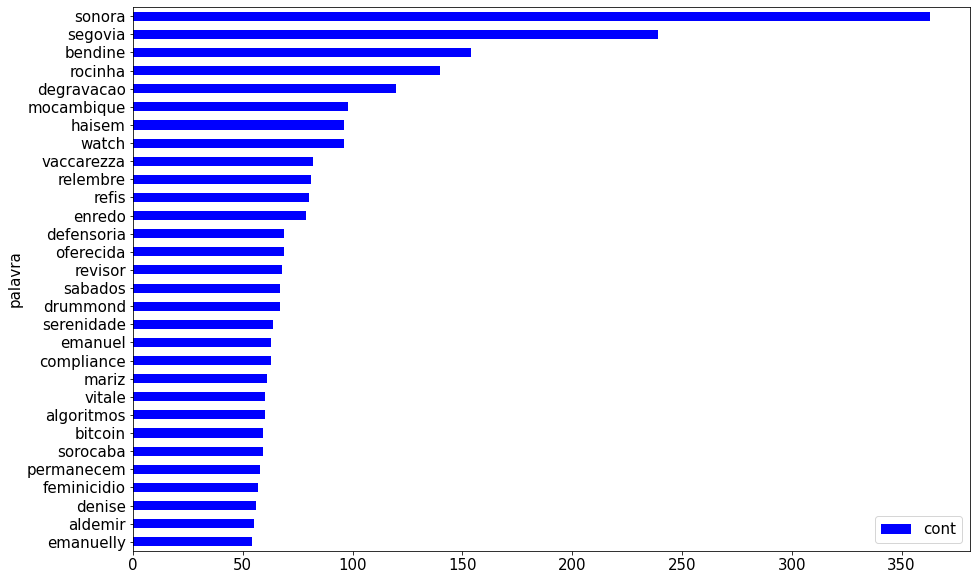

In [98]:
verdadeiro_para_falso = []
for palavra in verdadeiro_count.keys():
    if palavra not in falso_count.keys():
        verdadeiro_para_falso.append({'palavra': palavra, 'cont': verdadeiro_count[palavra]})
verdadeiro_para_falso = pd.DataFrame(verdadeiro_para_falso)
verdadeiro_para_falso.sort_values(by='cont', ascending=False)[0:20]

verdadeiro_para_falso.sort_values(by='cont', ascending=False, inplace=True)
verdadeiro_para_falso[:30].plot.barh(x='palavra', y='cont', color='blue').invert_yaxis()
plt.gcf().set_size_inches(15, 10)

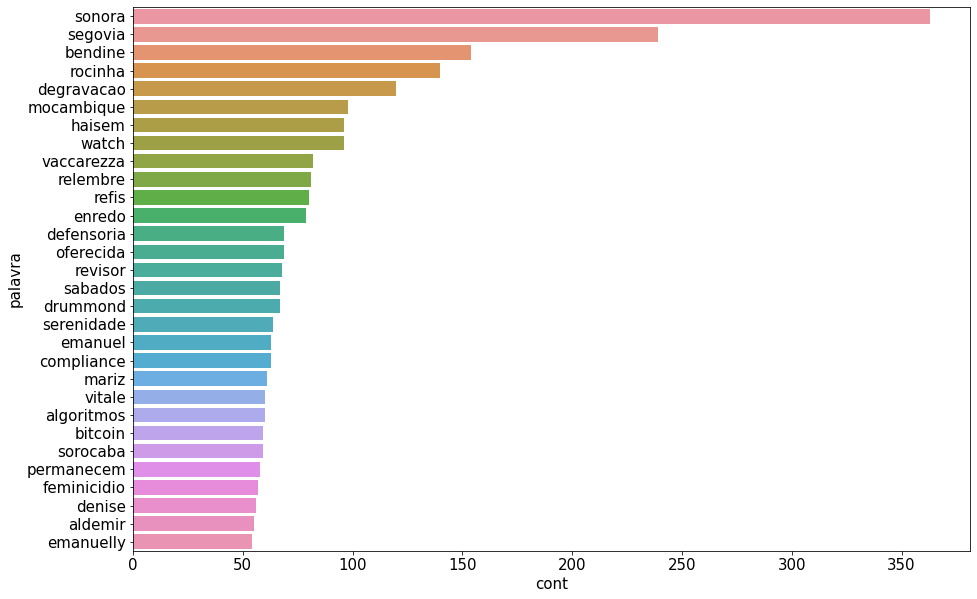

In [99]:
ax = sns.barplot(y='palavra', x='cont', data=verdadeiro_para_falso[:30])
plt.gcf().set_size_inches(15, 10)

## Construindo um modelo

- Funções utilitárias

In [77]:
def formatar_lote_de_noticias(noticias):
    lote = []
    for i, linha in noticias.iterrows():
        contagem = dict.fromkeys(vocabulario, 0)
        palavras = linha['texto'].split()
        
        for palavra in palavras:
            contagem[palavra] += 1
        lote.append(contagem)
    
    return pd.DataFrame(lote)

In [78]:
def formatar_lote_de_noticias_sim_nao(noticias):
    lote = []
    for i, linha in noticias.iterrows():
        contagem = dict.fromkeys(vocabulario, 0)
        palavras = linha['texto'].split()
        
        for palavra in palavras:
            contagem[palavra] = 1
        lote.append(contagem)
    
    return pd.DataFrame(lote)

In [79]:
def format_labels(y_train):
    rows = []
    for value in y_train:
        if value == 0:
            rows.append([0,1])
        else:
            rows.append([1,0])
    return rows

In [80]:
def classificar_noticia(est, noticia):
    classe = est.predict(formatar_lote_de_noticias(pd.DataFrame([{'texto':noticia}])))[0]
    return 'Verdadeiro' if classe == 1 else 'Falso'

In [81]:
def classify(result):
    if(result[0] == 0 and result[1] == 1):
        return 0
    else:
        return 1

- Construção dos modelos

In [82]:
tamanho_lote = 128

In [83]:
noticia = 'cloroquina salva milhoes em tratamento precoce'

In [84]:
noticias, classes = todas_noticias['texto'].to_frame(),todas_noticias['classificacao'].to_frame()

In [85]:
classes.classificacao = classes.classificacao.map(lambda x: 0 if x == 'falso' else 1)

In [86]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(noticias, classes['classificacao'].array, random_state=42)

validacao_treino, validacao_classe = X_test[:2*tamanho_lote], y_test[:2*tamanho_lote]

X_test, y_test = X_test[2*tamanho_lote:], y_test[2*tamanho_lote:]

In [87]:
len(X_test)

2872

In [88]:
x_test = formatar_lote_de_noticias(X_test)

In [89]:
x_test_sn = formatar_lote_de_noticias_sim_nao(X_test)

In [90]:
x_test_batch = formatar_lote_de_noticias(X_test[0:128]).to_numpy()
y_test_batch = np.asanyarray(format_labels(y_test[0:128].to_numpy()))

In [91]:
val_formated = formatar_lote_de_noticias(validacao_treino).to_numpy()
val_formated_class = np.asanyarray(format_labels(validacao_classe.to_numpy()))

In [92]:
val_formated_sn = formatar_lote_de_noticias_sim_nao(validacao_treino).to_numpy()
val_formated_class_sn = np.asanyarray(format_labels(validacao_classe.to_numpy()))

In [93]:
import joblib
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

target_names = ['Falso', 'Verdadeiro']

### Importando modelos utilizados

In [94]:
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import PassiveAggressiveClassifier
from keras.models import load_model
import tensorflow as tf

In [95]:
stats = []

## SGD Classifier

- Testando modelo SGD Classifier

In [119]:


est = SGDClassifier(loss='log', penalty='l2', tol=1e-3)

## Treinando

inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias(X_train[inicio_lote:fim_lote])
    est.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = est.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

Lote 1 of 73 - score: 0.62109375
Lote 2 of 73 - score: 0.4140625


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/willian/anaconda3/envs/tcc/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3427, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-119-51ff86dab16d>", line 12, in <module>
    x_train = formatar_lote_de_noticias(X_train[inicio_lote:fim_lote])
  File "<ipython-input-101-ce489489b177>", line 11, in formatar_lote_de_noticias
    return pd.DataFrame(lote)
  File "/home/willian/anaconda3/envs/tcc/lib/python3.9/site-packages/pandas/core/frame.py", line 570, in __init__
    arrays, columns = to_arrays(data, columns, dtype=dtype)
  File "/home/willian/anaconda3/envs/tcc/lib/python3.9/site-packages/pandas/core/internals/construction.py", line 530, in to_arrays
    return _list_of_dict_to_arrays(
  File "/home/willian/anaconda3/envs/tcc/lib/python3.9/site-packages/pandas/core/internals/construction.py", line 651, in _list_of_dict_to_arrays
    content = _convert_object_array(content, dtype

TypeError: object of type 'NoneType' has no len()

- Avaliando o modelo

### Exportando o modelo SGD

In [ ]:
joblib.dump(est, 'sgd.sav')

### Carregar modelo SGD

In [208]:
sgd_model = joblib.load('sgd.sav')

- Classificar usando modelo SGD

In [210]:
classificar_noticia(sgd_model, noticia)

'Falso'

- Resultados do modelo

In [211]:
sgd_model.score(x_test, y_test)

0.6086350974930362

## Confusion Matrix

In [212]:
sgd_pred = sgd_model.predict(x_test)

confusion_matrix(y_test, sgd_pred)

array([[1748,    0],
       [1124,    0]])

## Accuracy Score

In [218]:
set(sgd_pred)
set(y_test)

{0, 1}

In [213]:
accuracy_score(y_test, sgd_pred)

0.6086350974930362

In [214]:
from sklearn.metrics import precision_recall_fscore_support as score
precision,recall,fscore,support=score(y_test,sgd_pred,average='macro')
print('Precision : {}'.format(precision))
print('Recall    : {}'.format(recall))
print('F-score   : {}'.format(fscore))
print('Support   : {}'.format(support))

Precision : 0.3043175487465181
Recall    : 0.5
F-score   : 0.37835497835497833
Support   : None


/home/willian/anaconda3/envs/tcc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Classification Report

In [99]:
report = classification_report(y_test, sgd_pred, target_names=target_names,  output_dict=True)
report

/home/willian/anaconda3/envs/tcc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/willian/anaconda3/envs/tcc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/willian/anaconda3/envs/tcc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Falso': {'precision': 0.6086350974930362,
  'recall': 1.0,
  'f1-score': 0.7567099567099567,
  'support': 1748},
 'Verdadeiro': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 1124},
 'accuracy': 0.6086350974930362,
 'macro avg': {'precision': 0.3043175487465181,
  'recall': 0.5,
  'f1-score': 0.37835497835497833,
  'support': 2872},
 'weighted avg': {'precision': 0.3704366819003577,
  'recall': 0.6086350974930362,
  'f1-score': 0.4605602382761157,
  'support': 2872}}

In [100]:
sgd_stats = {'model': 'sgd_count', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

{'model': 'sgd_count',
 'accuracy': 0.6086350974930362,
 'recall': 0.5,
 'f1_score': 0.37835497835497833,
 'support': 2872,
 'falso_precision': 0.6086350974930362,
 'falso_recall': 1.0,
 'falso_f1_score': 0.7567099567099567,
 'verdadeiro_precision': 0.0,
 'verdadeiro_recall': 0.0,
 'verdadeiro_f1_score': 0.0}

In [101]:
stats.append(sgd_stats)

## SGD Classifier em dados de sim ou não

In [ ]:
est_sn = SGDClassifier(loss='log', penalty='l2', tol=1e-3)

## Treinando

inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias_sim_nao(X_train[inicio_lote:fim_lote])
    est_sn.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = est_sn.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo SGD (contains)

In [ ]:
joblib.dump(est_sn, 'sgdsn.sav')

### Carregar modelo SGD (contains)

In [102]:
sgdsn_model_sn = joblib.load('sgdsn.sav')

- Classificar usando modelo SGD (contains)

In [145]:
classificar_noticia(sgdsn_model_sn, noticia)

'Verdadeiro'

- Resultados do modelo





In [147]:
sgdsn_model_sn.score(x_test_sn, y_test)

0.45125348189415043

## Confusion Matrix

In [103]:
sgdsn_pred = sgdsn_model_sn.predict(x_test_sn)

confusion_matrix(y_test, sgdsn_pred)

array([[ 197, 1551],
       [ 122, 1002]])

## Accuracy Score

In [104]:
accuracy_score(y_test, sgdsn_pred)

0.4174791086350975

## Classification Report

In [105]:
report = classification_report(y_test, sgdsn_pred, target_names=target_names, output_dict=True)
report

{'Falso': {'precision': 0.6175548589341693,
  'recall': 0.11270022883295194,
  'f1-score': 0.19061441702951137,
  'support': 1748},
 'Verdadeiro': {'precision': 0.39247943595769685,
  'recall': 0.891459074733096,
  'f1-score': 0.5450095186293175,
  'support': 1124},
 'accuracy': 0.4174791086350975,
 'macro avg': {'precision': 0.5050171474459331,
  'recall': 0.5020796517830239,
  'f1-score': 0.3678119678294144,
  'support': 2872},
 'weighted avg': {'precision': 0.5294682379642686,
  'recall': 0.4174791086350975,
  'f1-score': 0.32931222141606503,
  'support': 2872}}

In [106]:
sgd_stats = {'model': 'sgd_contains', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

{'model': 'sgd_contains',
 'accuracy': 0.4174791086350975,
 'recall': 0.5020796517830239,
 'f1_score': 0.3678119678294144,
 'support': 2872,
 'falso_precision': 0.6175548589341693,
 'falso_recall': 0.11270022883295194,
 'falso_f1_score': 0.19061441702951137,
 'verdadeiro_precision': 0.39247943595769685,
 'verdadeiro_recall': 0.891459074733096,
 'verdadeiro_f1_score': 0.5450095186293175}

In [107]:
stats.append(sgd_stats)

## MultinomialNB

In [ ]:
clf = MultinomialNB()
## Treinando
inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias(X_train[inicio_lote:fim_lote])
    clf.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = clf.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo MultinomialNB

In [ ]:
joblib.dump(est_sn, 'MultinomialNB.sav')

### Carregar modelo MultinomialNB

In [108]:
multinb_model = joblib.load('MultinomialNB.sav')

- Classificar usando modelo MultinomialNB

In [155]:
classificar_noticia(multinb_model, noticia)

'Falso'

- Resultados do modelo

In [109]:
multinb_model.score(x_test, y_test)

0.608983286908078

## Confusion Matrix

In [110]:
multinb_model_pred = multinb_model.predict(x_test)

confusion_matrix(y_test, multinb_model_pred)

array([[1748,    0],
       [1123,    1]])

## Accuracy Score

In [158]:
accuracy_score(y_test, multinb_model_pred)

0.6079387186629527

## Classification Report

In [111]:
report = classification_report(y_test, multinb_model_pred, target_names=target_names, output_dict=True)
report

{'Falso': {'precision': 0.6088470916057123,
  'recall': 1.0,
  'f1-score': 0.7568737822039402,
  'support': 1748},
 'Verdadeiro': {'precision': 1.0,
  'recall': 0.0008896797153024911,
  'f1-score': 0.0017777777777777779,
  'support': 1124},
 'accuracy': 0.608983286908078,
 'macro avg': {'precision': 0.8044235458028561,
  'recall': 0.5004448398576512,
  'f1-score': 0.379325779990859,
  'support': 2872},
 'weighted avg': {'precision': 0.761930611464758,
  'recall': 0.608983286908078,
  'f1-score': 0.4613557080482973,
  'support': 2872}}

In [112]:
sgd_stats = {'model': 'multinomial_count', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

{'model': 'multinomial_count',
 'accuracy': 0.608983286908078,
 'recall': 0.5004448398576512,
 'f1_score': 0.379325779990859,
 'support': 2872,
 'falso_precision': 0.6088470916057123,
 'falso_recall': 1.0,
 'falso_f1_score': 0.7568737822039402,
 'verdadeiro_precision': 1.0,
 'verdadeiro_recall': 0.0008896797153024911,
 'verdadeiro_f1_score': 0.0017777777777777779}

In [113]:
stats.append(sgd_stats)

## MultiomailNB Classifier em dados de sim ou não

In [ ]:
clf_sn = MultinomialNB()

inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias_sim_nao(X_train[inicio_lote:fim_lote])
    clf_sn.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = clf_sn.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo MultinomialNB

In [ ]:
joblib.dump(est_sn, 'MultinomialNBSN.sav')

### Carregar modelo MultinomialNB

In [116]:
multinb_model_sn = joblib.load('MultinomialNB.sav')

- Classificar usando modelo MultinomialNB

In [164]:
classificar_noticia(multinb_model_sn, noticia)

'Falso'

- Resultados do modelo

In [165]:
multinb_model_sn.score(x_test, y_test)

0.6079387186629527

## Confusion Matrix

In [117]:
multinb_model_pred_sn = multinb_model_sn.predict(x_test_sn)
confusion_matrix(y_test, multinb_model_pred_sn)

array([[1748,    0],
       [1123,    1]])

## Accuracy Score

In [167]:
accuracy_score(y_test, multinb_model_pred_sn)

0.6079387186629527

## Classification Report

In [118]:
report = classification_report(y_test, multinb_model_pred_sn, target_names=target_names, output_dict=True)
report

{'Falso': {'precision': 0.6088470916057123,
  'recall': 1.0,
  'f1-score': 0.7568737822039402,
  'support': 1748},
 'Verdadeiro': {'precision': 1.0,
  'recall': 0.0008896797153024911,
  'f1-score': 0.0017777777777777779,
  'support': 1124},
 'accuracy': 0.608983286908078,
 'macro avg': {'precision': 0.8044235458028561,
  'recall': 0.5004448398576512,
  'f1-score': 0.379325779990859,
  'support': 2872},
 'weighted avg': {'precision': 0.761930611464758,
  'recall': 0.608983286908078,
  'f1-score': 0.4613557080482973,
  'support': 2872}}

In [119]:
sgd_stats = {'model': 'multinomial_contains', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

{'model': 'multinomial_contains',
 'accuracy': 0.608983286908078,
 'recall': 0.5004448398576512,
 'f1_score': 0.379325779990859,
 'support': 2872,
 'falso_precision': 0.6088470916057123,
 'falso_recall': 1.0,
 'falso_f1_score': 0.7568737822039402,
 'verdadeiro_precision': 1.0,
 'verdadeiro_recall': 0.0008896797153024911,
 'verdadeiro_f1_score': 0.0017777777777777779}

In [120]:
stats.append(sgd_stats)

# Perceptron

In [ ]:
percep = Perceptron()

inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias(X_train[inicio_lote:fim_lote])
    percep.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = percep.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo Perceptron

In [ ]:
joblib.dump(percep, 'Percep.sav')

### Carregar modelo Perceptron


In [121]:
perceb_model = joblib.load('Percep.sav')

- Classificar usando modelo Perceptron

In [173]:
classificar_noticia(perceb_model, noticia)

'Falso'

- Resultados do modelo

In [174]:
perceb_model.score(x_test, y_test)

0.6006267409470752


## Confusion Matrix

In [122]:
perceb_model_pred = perceb_model.predict(x_test)
confusion_matrix(y_test, perceb_model_pred)

array([[1721,   27],
       [1112,   12]])

## Accuracy Score

In [176]:

accuracy_score(y_test, perceb_model_pred)

0.6006267409470752

## Classification Report

In [123]:
report = classification_report(y_test, perceb_model_pred, target_names=target_names, output_dict=True)
report

{'Falso': {'precision': 0.6074832333215673,
  'recall': 0.9845537757437071,
  'f1-score': 0.751364330932111,
  'support': 1748},
 'Verdadeiro': {'precision': 0.3076923076923077,
  'recall': 0.010676156583629894,
  'f1-score': 0.02063628546861565,
  'support': 1124},
 'accuracy': 0.6034122562674095,
 'macro avg': {'precision': 0.4575877705069375,
  'recall': 0.49761496616366846,
  'f1-score': 0.3860003082003633,
  'support': 2872},
 'weighted avg': {'precision': 0.4901555869401997,
  'recall': 0.6034122562674095,
  'f1-score': 0.4653830206601859,
  'support': 2872}}

In [124]:
sgd_stats = {'model': 'percep_count', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

{'model': 'percep_count',
 'accuracy': 0.6034122562674095,
 'recall': 0.49761496616366846,
 'f1_score': 0.3860003082003633,
 'support': 2872,
 'falso_precision': 0.6074832333215673,
 'falso_recall': 0.9845537757437071,
 'falso_f1_score': 0.751364330932111,
 'verdadeiro_precision': 0.3076923076923077,
 'verdadeiro_recall': 0.010676156583629894,
 'verdadeiro_f1_score': 0.02063628546861565}

In [125]:
stats.append(sgd_stats)

## Perceptron sim ou não

In [ ]:
inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias_sim_nao(X_train[inicio_lote:fim_lote])
    percep_sn.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = percep_sn.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo Perceptron

In [ ]:
joblib.dump(percep_sn, 'percep_sn.sav')

### Carregar modelo Perceptron

In [126]:
perceb_model_sn = joblib.load('percep_sn.sav')

- Classificar usando modelo Perceptron

In [182]:
classificar_noticia(perceb_model_sn, noticia)

'Verdadeiro'

- Resultados do modelo

In [183]:
perceb_model_sn.score(x_test_sn, y_test)

0.39519498607242337

## Confusion Matrix

In [127]:
perceb_model_pred_sn = perceb_model_sn.predict(x_test_sn)
confusion_matrix(y_test, perceb_model_pred_sn)

array([[  67, 1681],
       [  72, 1052]])

## Accuracy Score


In [185]:
accuracy_score(y_test, perceb_model_pred_sn)

0.39519498607242337

## Classification Report

In [128]:
report = classification_report(y_test, perceb_model_pred_sn, target_names=target_names, output_dict=True)
report

{'Falso': {'precision': 0.48201438848920863,
  'recall': 0.03832951945080092,
  'f1-score': 0.07101218865924748,
  'support': 1748},
 'Verdadeiro': {'precision': 0.384924990852543,
  'recall': 0.9359430604982206,
  'f1-score': 0.5455016852476018,
  'support': 1124},
 'accuracy': 0.3896239554317549,
 'macro avg': {'precision': 0.43346968967087585,
  'recall': 0.48713628997451075,
  'f1-score': 0.30825693695342465,
  'support': 2872},
 'weighted avg': {'precision': 0.44401700584867515,
  'recall': 0.3896239554317549,
  'f1-score': 0.2567107242321271,
  'support': 2872}}

In [129]:
sgd_stats = {'model': 'percep_contains', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

{'model': 'percep_contains',
 'accuracy': 0.3896239554317549,
 'recall': 0.48713628997451075,
 'f1_score': 0.30825693695342465,
 'support': 2872,
 'falso_precision': 0.48201438848920863,
 'falso_recall': 0.03832951945080092,
 'falso_f1_score': 0.07101218865924748,
 'verdadeiro_precision': 0.384924990852543,
 'verdadeiro_recall': 0.9359430604982206,
 'verdadeiro_f1_score': 0.5455016852476018}

In [130]:
stats.append(sgd_stats)

## Bernouli

In [ ]:
bern_count = BernoulliNB()
inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias(X_train[inicio_lote:fim_lote])
    bern_count.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = bern_count.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo Perceptron

In [ ]:
joblib.dump(percep_sn, 'bernouli.sav')

### Carregar modelo Perceptron

In [131]:
bern_model = joblib.load('bernouli.sav')

- Classificar usando modelo Perceptron

In [119]:
classificar_noticia(bern_model, noticia)

'Falso'

- Resultados do modelo

In [120]:
bern_model.score(x_test, y_test)

0.8373955431754875

## Confusion Matrix

In [132]:
bern_model_pred = bern_model.predict(x_test)
confusion_matrix(y_test, bern_model_pred)

array([[1728,   20],
       [ 445,  679]])

## Accuracy Score

In [122]:
accuracy_score(y_test, bern_model_pred)

0.8373955431754875

## Classification Report

In [133]:
report = classification_report(y_test, bern_model_pred, target_names=target_names, output_dict=True)
report

{'Falso': {'precision': 0.7952139898757478,
  'recall': 0.988558352402746,
  'f1-score': 0.881407804131599,
  'support': 1748},
 'Verdadeiro': {'precision': 0.9713876967095851,
  'recall': 0.6040925266903915,
  'f1-score': 0.7449259462424576,
  'support': 1124},
 'accuracy': 0.838091922005571,
 'macro avg': {'precision': 0.8833008432926664,
  'recall': 0.7963254395465688,
  'f1-score': 0.8131668751870282,
  'support': 2872},
 'weighted avg': {'precision': 0.864162195475063,
  'recall': 0.838091922005571,
  'f1-score': 0.8279935951248458,
  'support': 2872}}

In [134]:
sgd_stats = {'model': 'bernouli_count', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

{'model': 'bernouli_count',
 'accuracy': 0.838091922005571,
 'recall': 0.7963254395465688,
 'f1_score': 0.8131668751870282,
 'support': 2872,
 'falso_precision': 0.7952139898757478,
 'falso_recall': 0.988558352402746,
 'falso_f1_score': 0.881407804131599,
 'verdadeiro_precision': 0.9713876967095851,
 'verdadeiro_recall': 0.6040925266903915,
 'verdadeiro_f1_score': 0.7449259462424576}

In [135]:
stats.append(sgd_stats)

In [199]:
stats

[{'model': 'sgd_count',
  'accuracy': 0.6117688022284122,
  'recall': 0.5040035587188612,
  'f1_score': 0.38703698492974037,
  'support': 2872,
  'falso_precision': 0.6105483758295495,
  'falso_recall': 1.0,
  'falso_f1_score': 0.7581869442637172,
  'verdadeiro_precision': 1.0,
  'verdadeiro_recall': 0.00800711743772242,
  'verdadeiro_f1_score': 0.015887025595763462},
 {'model': 'sgd_contains',
  'accuracy': 0.45125348189415043,
  'recall': 0.5087054243996189,
  'f1_score': 0.4379410457194941,
  'support': 2872,
  'falso_precision': 0.626099706744868,
  'falso_recall': 0.244279176201373,
  'falso_f1_score': 0.35144032921810703,
  'verdadeiro_precision': 0.39680365296803655,
  'verdadeiro_recall': 0.7731316725978647,
  'verdadeiro_f1_score': 0.5244417622208811},
 {'model': 'multinomial_count',
  'accuracy': 0.6079387186629527,
  'recall': 0.4995867162878572,
  'f1_score': 0.3789194537655026,
  'support': 2872,
  'falso_precision': 0.6084379358437936,
  'falso_recall': 0.9982837528604119

## Bernouli Sim ou Não

In [ ]:
inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias_sim_nao(X_train[inicio_lote:fim_lote])
    bern.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = bern.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo Bernouli

In [ ]:
joblib.dump(bern, 'bernoulisn.sav')

### Carregar modelo Perceptron

In [136]:
bern_model_sn = joblib.load('bernoulisn.sav')

- Classificar usando modelo Perceptron

In [201]:
classificar_noticia(bern_model_sn, noticia)

'Falso'

- Resultados do modelo

In [202]:
bern_model_sn.score(x_test_sn, y_test)

0.8391364902506964

## Confusion Matrix

In [137]:
bern_model_sn_pred = bern_model_sn.predict(x_test_sn)
confusion_matrix(y_test, bern_model_sn_pred)

array([[1728,   20],
       [ 445,  679]])

## Accuracy Score

In [204]:
accuracy_score(y_test, bern_model_sn_pred)

0.8391364902506964

## Classification Report

In [138]:
report = classification_report(y_test, bern_model_sn_pred, target_names=target_names, output_dict=True)
report

{'Falso': {'precision': 0.7952139898757478,
  'recall': 0.988558352402746,
  'f1-score': 0.881407804131599,
  'support': 1748},
 'Verdadeiro': {'precision': 0.9713876967095851,
  'recall': 0.6040925266903915,
  'f1-score': 0.7449259462424576,
  'support': 1124},
 'accuracy': 0.838091922005571,
 'macro avg': {'precision': 0.8833008432926664,
  'recall': 0.7963254395465688,
  'f1-score': 0.8131668751870282,
  'support': 2872},
 'weighted avg': {'precision': 0.864162195475063,
  'recall': 0.838091922005571,
  'f1-score': 0.8279935951248458,
  'support': 2872}}

In [139]:
sgd_stats = {'model': 'benouli_contains', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

{'model': 'benouli_contains',
 'accuracy': 0.838091922005571,
 'recall': 0.7963254395465688,
 'f1_score': 0.8131668751870282,
 'support': 2872,
 'falso_precision': 0.7952139898757478,
 'falso_recall': 0.988558352402746,
 'falso_f1_score': 0.881407804131599,
 'verdadeiro_precision': 0.9713876967095851,
 'verdadeiro_recall': 0.6040925266903915,
 'verdadeiro_f1_score': 0.7449259462424576}

In [140]:
stats.append(sgd_stats)

## Passive agressive classifier

In [ ]:
passive = PassiveAggressiveClassifier()

inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias(X_train[inicio_lote:fim_lote])
    passive.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = passive.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo Passive Agressive

In [ ]:
joblib.dump(passive, 'passive.sav')

### Carregar modelo Passive Agressive

In [141]:
passive_model = joblib.load('passive.sav')

- Classificar usando modelo Passive Agressive

In [212]:
classificar_noticia(passive_model, noticia)

'Falso'

- Resultados do modelo

In [213]:
passive_model.score(x_test, y_test)

0.616991643454039

## Confusion Matrix

In [142]:
passive_model_pred = passive_model.predict(x_test)
confusion_matrix(y_test, passive_model_pred)

array([[1706,   42],
       [1103,   21]])

## Accuracy Score

In [215]:
accuracy_score(y_test, passive_model_pred)

0.616991643454039

## Classification Report

In [143]:
report = classification_report(y_test, passive_model_pred, target_names=target_names, output_dict=True)
report

{'Falso': {'precision': 0.6073335706657174,
  'recall': 0.9759725400457666,
  'f1-score': 0.7487382049594032,
  'support': 1748},
 'Verdadeiro': {'precision': 0.3333333333333333,
  'recall': 0.018683274021352312,
  'f1-score': 0.035383319292333605,
  'support': 1124},
 'accuracy': 0.6013231197771588,
 'macro avg': {'precision': 0.47033345199952536,
  'recall': 0.49732790703355945,
  'f1-score': 0.39206076212586843,
  'support': 2872},
 'weighted avg': {'precision': 0.5000994944952439,
  'recall': 0.6013231197771588,
  'f1-score': 0.46955613967744425,
  'support': 2872}}

In [144]:
sgd_stats = {'model': 'passive_count', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

{'model': 'passive_count',
 'accuracy': 0.6013231197771588,
 'recall': 0.49732790703355945,
 'f1_score': 0.39206076212586843,
 'support': 2872,
 'falso_precision': 0.6073335706657174,
 'falso_recall': 0.9759725400457666,
 'falso_f1_score': 0.7487382049594032,
 'verdadeiro_precision': 0.3333333333333333,
 'verdadeiro_recall': 0.018683274021352312,
 'verdadeiro_f1_score': 0.035383319292333605}

In [145]:
stats.append(sgd_stats)


## Passive agressive classifier Sim Não

In [ ]:
passive_sn = PassiveAggressiveClassifier()

inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias(X_train[inicio_lote:fim_lote])
    passive_sn.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = passive_sn.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo Passive Agressive

In [ ]:
joblib.dump(passive_sn, 'passivesn.sav')

### Carregar modelo Perceptron

In [146]:
passive_model_sn = joblib.load('passivesn.sav')

- Classificar usando modelo Perceptron

In [225]:
classificar_noticia(passive_model_sn, noticia)

'Falso'

- Resultados do modelo

In [226]:
passive_model_sn.score(x_test_sn, y_test)

0.6462395543175488

## Confusion Matrix

In [147]:
passive_model_sn_pred = passive_model_sn.predict(x_test_sn)
confusion_matrix(y_test, passive_model_sn_pred)

array([[1726,   22],
       [1073,   51]])

## Accuracy Score

In [228]:
accuracy_score(y_test, passive_model_sn_pred)

0.6462395543175488

## Classification Report

In [148]:
report = classification_report(y_test, passive_model_sn_pred, target_names=target_names, output_dict=True)
report

{'Falso': {'precision': 0.61664880314398,
  'recall': 0.9874141876430206,
  'f1-score': 0.7591818781614251,
  'support': 1748},
 'Verdadeiro': {'precision': 0.6986301369863014,
  'recall': 0.045373665480427046,
  'f1-score': 0.08521303258145362,
  'support': 1124},
 'accuracy': 0.6187325905292479,
 'macro avg': {'precision': 0.6576394700651407,
  'recall': 0.5163939265617238,
  'f1-score': 0.4221974553714394,
  'support': 2872},
 'weighted avg': {'precision': 0.6487334198705709,
  'recall': 0.6187325905292479,
  'f1-score': 0.4954141266182887,
  'support': 2872}}

In [149]:
sgd_stats = {'model': 'passive_contains', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

{'model': 'passive_contains',
 'accuracy': 0.6187325905292479,
 'recall': 0.5163939265617238,
 'f1_score': 0.4221974553714394,
 'support': 2872,
 'falso_precision': 0.61664880314398,
 'falso_recall': 0.9874141876430206,
 'falso_f1_score': 0.7591818781614251,
 'verdadeiro_precision': 0.6986301369863014,
 'verdadeiro_recall': 0.045373665480427046,
 'verdadeiro_f1_score': 0.08521303258145362}

In [150]:
stats.append(sgd_stats)

## Redes Neurais

In [154]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(12, input_dim=82080),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax')
])

lossss = tf.keras.losses.BinaryCrossentropy(
    from_logits=False, label_smoothing=0, reduction="auto", name="binary_crossentropy"
)

model.compile(optimizer='adam',
              loss=lossss,
              metrics=['accuracy'])

In [155]:


inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1

# model.save('keras_count.h5')
while True:
#     /model = load_model('keras_count.h5')
    x_train = formatar_lote_de_noticias(X_train[inicio_lote:fim_lote])
    y_tr = np.asanyarray(format_labels(y_train[inicio_lote:fim_lote].to_numpy()))
    model.fit(x_train.to_numpy(), y_tr, epochs=10)
#     model.save('keras_count.h5')
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

Epoch 1/10
4/4 [==============================] - 1s 30ms/step - loss: 0.6257 - accuracy: 0.4500
Epoch 2/10
4/4 [==============================] - 0s 42ms/step - loss: 0.5252 - accuracy: 0.4875
Epoch 3/10
4/4 [==============================] - 0s 26ms/step - loss: 0.4979 - accuracy: 0.6667
Epoch 4/10
4/4 [==============================] - 0s 30ms/step - loss: 0.4755 - accuracy: 0.9698
Epoch 5/10
4/4 [==============================] - 0s 34ms/step - loss: 0.4717 - accuracy: 0.9740
Epoch 6/10
4/4 [==============================] - 0s 33ms/step - loss: 0.4155 - accuracy: 0.9771
Epoch 7/10
4/4 [==============================] - 0s 48ms/step - loss: 0.3896 - accuracy: 0.9865
Epoch 8/10
4/4 [==============================] - 0s 41ms/step - loss: 0.3587 - accuracy: 0.9719
Epoch 9/10
4/4 [==============================] - 0s 38ms/step - loss: 0.3274 - accuracy: 0.9625
Epoch 10/10
4/4 [==============================] - 0s 36ms/step - loss: 0.2978 - accuracy: 0.9677
Epoch 1/10
4/4 [=============

4/4 [==============================] - 0s 37ms/step - loss: 0.0535 - accuracy: 0.9922
Epoch 10/10
4/4 [==============================] - 0s 34ms/step - loss: 0.0487 - accuracy: 0.9922
Epoch 1/10
4/4 [==============================] - 0s 35ms/step - loss: 0.5031 - accuracy: 0.8203
Epoch 2/10
4/4 [==============================] - 0s 41ms/step - loss: 0.2290 - accuracy: 0.8828
Epoch 3/10
4/4 [==============================] - 0s 36ms/step - loss: 0.1616 - accuracy: 0.9219
Epoch 4/10
4/4 [==============================] - 0s 28ms/step - loss: 0.1306 - accuracy: 0.9531
Epoch 5/10
4/4 [==============================] - 0s 42ms/step - loss: 0.1061 - accuracy: 0.9609
Epoch 6/10
4/4 [==============================] - 0s 35ms/step - loss: 0.0881 - accuracy: 0.9844
Epoch 7/10
4/4 [==============================] - 0s 37ms/step - loss: 0.0739 - accuracy: 1.0000
Epoch 8/10
4/4 [==============================] - 0s 45ms/step - loss: 0.0639 - accuracy: 1.0000
Epoch 9/10
4/4 [========================

4/4 [==============================] - 0s 43ms/step - loss: 0.0602 - accuracy: 0.9922
Epoch 8/10
4/4 [==============================] - 0s 38ms/step - loss: 0.0507 - accuracy: 0.9922
Epoch 9/10
4/4 [==============================] - 0s 31ms/step - loss: 0.0444 - accuracy: 0.9922
Epoch 10/10
4/4 [==============================] - 0s 40ms/step - loss: 0.0399 - accuracy: 0.9922
Epoch 1/10
4/4 [==============================] - 0s 37ms/step - loss: 0.5900 - accuracy: 0.8359
Epoch 2/10
4/4 [==============================] - 0s 42ms/step - loss: 0.2704 - accuracy: 0.8828
Epoch 3/10
4/4 [==============================] - 0s 45ms/step - loss: 0.1734 - accuracy: 0.9219
Epoch 4/10
4/4 [==============================] - 0s 48ms/step - loss: 0.1456 - accuracy: 0.9375
Epoch 5/10
4/4 [==============================] - 0s 38ms/step - loss: 0.1205 - accuracy: 0.9609
Epoch 6/10
4/4 [==============================] - 0s 30ms/step - loss: 0.0904 - accuracy: 0.9766
Epoch 7/10
4/4 [========================

4/4 [==============================] - 0s 46ms/step - loss: 0.0500 - accuracy: 0.9844
Epoch 6/10
4/4 [==============================] - 0s 36ms/step - loss: 0.0366 - accuracy: 0.9922
Epoch 7/10
4/4 [==============================] - 0s 31ms/step - loss: 0.0291 - accuracy: 0.9922
Epoch 8/10
4/4 [==============================] - 0s 37ms/step - loss: 0.0246 - accuracy: 0.9922
Epoch 9/10
4/4 [==============================] - 0s 40ms/step - loss: 0.0211 - accuracy: 1.0000
Epoch 10/10
4/4 [==============================] - 0s 34ms/step - loss: 0.0182 - accuracy: 1.0000
Epoch 1/10
4/4 [==============================] - 0s 43ms/step - loss: 0.6056 - accuracy: 0.8828
Epoch 2/10
4/4 [==============================] - 0s 42ms/step - loss: 0.3564 - accuracy: 0.8984
Epoch 3/10
4/4 [==============================] - 0s 46ms/step - loss: 0.1403 - accuracy: 0.9531
Epoch 4/10
4/4 [==============================] - 0s 46ms/step - loss: 0.0815 - accuracy: 0.9688
Epoch 5/10
4/4 [========================

4/4 [==============================] - 0s 39ms/step - loss: 0.1019 - accuracy: 0.9609
Epoch 4/10
4/4 [==============================] - 0s 48ms/step - loss: 0.0485 - accuracy: 0.9766
Epoch 5/10
4/4 [==============================] - 0s 40ms/step - loss: 0.0309 - accuracy: 0.9922
Epoch 6/10
4/4 [==============================] - 0s 55ms/step - loss: 0.0247 - accuracy: 0.9922
Epoch 7/10
4/4 [==============================] - 0s 54ms/step - loss: 0.0191 - accuracy: 1.0000
Epoch 8/10
4/4 [==============================] - 0s 56ms/step - loss: 0.0159 - accuracy: 1.0000
Epoch 9/10
4/4 [==============================] - 0s 44ms/step - loss: 0.0123 - accuracy: 1.0000
Epoch 10/10
4/4 [==============================] - 0s 53ms/step - loss: 0.0107 - accuracy: 1.0000
Epoch 1/10
4/4 [==============================] - 0s 41ms/step - loss: 0.3855 - accuracy: 0.8672
Epoch 2/10
4/4 [==============================] - 0s 59ms/step - loss: 0.2563 - accuracy: 0.9062
Epoch 3/10
4/4 [========================

- Avaliando o modelo

### Exportando o modelo Rede Neural

In [158]:
model.save('keras_finished_count_2.h5')

### Carregar modelo Rede Neural

In [159]:
keras_model = load_model('keras_finished_count_2.h5')

- Resultados do modelo


In [144]:
score, acc = keras_model.evaluate(x_test_batch, y_test_batch)
print(f"Score: {score}")
print(f"Accuracy: {acc}")

4/4 [==============================] - 1s 37ms/step - loss: 0.6874 - accuracy: 0.6484
Score: 0.6873911023139954
Accuracy: 0.6484375


## Confusion Matrix

In [160]:
y_pred_keras = keras_model.predict(x_test.to_numpy()).round()
y_pred_keras = [classify(result) for result in y_pred_keras]
confusion_matrix(y_test, y_pred_keras)

array([[1609,  139],
       [ 189,  935]])

## Accuracy Score

In [157]:
accuracy_score(y_test, y_pred_keras)

0.8857938718662952

## Classification Report

In [161]:
report = classification_report(y_test, y_pred_keras, target_names=target_names, output_dict=True)
report

{'Falso': {'precision': 0.8948832035595106,
  'recall': 0.9204805491990846,
  'f1-score': 0.9075014100394811,
  'support': 1748},
 'Verdadeiro': {'precision': 0.8705772811918063,
  'recall': 0.8318505338078291,
  'f1-score': 0.8507734303912647,
  'support': 1124},
 'accuracy': 0.8857938718662952,
 'macro avg': {'precision': 0.8827302423756584,
  'recall': 0.8761655415034568,
  'f1-score': 0.879137420215373,
  'support': 2872},
 'weighted avg': {'precision': 0.8853707186217322,
  'recall': 0.8857938718662952,
  'f1-score': 0.8853000698150401,
  'support': 2872}}

In [162]:
sgd_stats = {'model': 'keras_count', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

{'model': 'keras_count',
 'accuracy': 0.8857938718662952,
 'recall': 0.8761655415034568,
 'f1_score': 0.879137420215373,
 'support': 2872,
 'falso_precision': 0.8948832035595106,
 'falso_recall': 0.9204805491990846,
 'falso_f1_score': 0.9075014100394811,
 'verdadeiro_precision': 0.8705772811918063,
 'verdadeiro_recall': 0.8318505338078291,
 'verdadeiro_f1_score': 0.8507734303912647}

In [163]:
stats.append(sgd_stats)

## Keras Contains

In [167]:
model_contains = tf.keras.models.Sequential([
  tf.keras.layers.Dense(12, input_dim=82080),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax')
])

lossss = tf.keras.losses.BinaryCrossentropy(
    from_logits=False, label_smoothing=0, reduction="auto", name="binary_crossentropy"
)

model_contains.compile(optimizer='adam',
              loss=lossss,
              metrics=['accuracy'])

In [168]:
inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1

# model.save('keras_count.h5')
while True:
#     /model = load_model('keras_count.h5')
    x_train = formatar_lote_de_noticias_sim_nao(X_train[inicio_lote:fim_lote])
    y_tr = np.asanyarray(format_labels(y_train[inicio_lote:fim_lote].to_numpy()))
    model_contains.fit(x_train.to_numpy(), y_tr, epochs=10)
#     model.save('keras_count.h5')
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

Epoch 1/10
4/4 [==============================] - 1s 25ms/step - loss: 0.6723 - accuracy: 0.4865
Epoch 2/10
4/4 [==============================] - 0s 22ms/step - loss: 0.5573 - accuracy: 0.7365
Epoch 3/10
4/4 [==============================] - 0s 29ms/step - loss: 0.4629 - accuracy: 0.9292
Epoch 4/10
4/4 [==============================] - 0s 26ms/step - loss: 0.4237 - accuracy: 0.9344
Epoch 5/10
4/4 [==============================] - 0s 29ms/step - loss: 0.3738 - accuracy: 0.9490
Epoch 6/10
4/4 [==============================] - 0s 34ms/step - loss: 0.3331 - accuracy: 0.9292
Epoch 7/10
4/4 [==============================] - 0s 30ms/step - loss: 0.2881 - accuracy: 0.9271
Epoch 8/10
4/4 [==============================] - 0s 32ms/step - loss: 0.2708 - accuracy: 0.9521
Epoch 9/10
4/4 [==============================] - 0s 34ms/step - loss: 0.2609 - accuracy: 0.9260
Epoch 10/10
4/4 [==============================] - 0s 38ms/step - loss: 0.2203 - accuracy: 0.9583
Epoch 1/10
4/4 [=============

4/4 [==============================] - 0s 37ms/step - loss: 0.0192 - accuracy: 1.0000
Epoch 10/10
4/4 [==============================] - 0s 32ms/step - loss: 0.0170 - accuracy: 1.0000
Epoch 1/10
4/4 [==============================] - 0s 52ms/step - loss: 0.5991 - accuracy: 0.7812
Epoch 2/10
4/4 [==============================] - 0s 58ms/step - loss: 0.2624 - accuracy: 0.8594
Epoch 3/10
4/4 [==============================] - 0s 33ms/step - loss: 0.1557 - accuracy: 0.9297
Epoch 4/10
4/4 [==============================] - 0s 28ms/step - loss: 0.1033 - accuracy: 0.9531
Epoch 5/10
4/4 [==============================] - 0s 32ms/step - loss: 0.0760 - accuracy: 0.9844
Epoch 6/10
4/4 [==============================] - 0s 37ms/step - loss: 0.0501 - accuracy: 0.9922
Epoch 7/10
4/4 [==============================] - 0s 41ms/step - loss: 0.0380 - accuracy: 0.9922
Epoch 8/10
4/4 [==============================] - 0s 45ms/step - loss: 0.0304 - accuracy: 1.0000
Epoch 9/10
4/4 [========================

4/4 [==============================] - 0s 35ms/step - loss: 0.0418 - accuracy: 0.9922
Epoch 8/10
4/4 [==============================] - 0s 27ms/step - loss: 0.0354 - accuracy: 0.9922
Epoch 9/10
4/4 [==============================] - 0s 51ms/step - loss: 0.0306 - accuracy: 0.9922
Epoch 10/10
4/4 [==============================] - 0s 39ms/step - loss: 0.0273 - accuracy: 0.9922
Epoch 1/10
4/4 [==============================] - 0s 35ms/step - loss: 0.3739 - accuracy: 0.8047
Epoch 2/10
4/4 [==============================] - 0s 45ms/step - loss: 0.2187 - accuracy: 0.8906
Epoch 3/10
4/4 [==============================] - 0s 38ms/step - loss: 0.1651 - accuracy: 0.9062
Epoch 4/10
4/4 [==============================] - 0s 53ms/step - loss: 0.1196 - accuracy: 0.9453
Epoch 5/10
4/4 [==============================] - 0s 50ms/step - loss: 0.0905 - accuracy: 0.9609
Epoch 6/10
4/4 [==============================] - 0s 47ms/step - loss: 0.0629 - accuracy: 0.9688
Epoch 7/10
4/4 [========================

4/4 [==============================] - 0s 41ms/step - loss: 0.0789 - accuracy: 0.9766
Epoch 6/10
4/4 [==============================] - 0s 46ms/step - loss: 0.0634 - accuracy: 0.9844
Epoch 7/10
4/4 [==============================] - 0s 48ms/step - loss: 0.0496 - accuracy: 0.9844
Epoch 8/10
4/4 [==============================] - 0s 52ms/step - loss: 0.0376 - accuracy: 0.9922
Epoch 9/10
4/4 [==============================] - 0s 47ms/step - loss: 0.0320 - accuracy: 1.0000
Epoch 10/10
4/4 [==============================] - 0s 55ms/step - loss: 0.0279 - accuracy: 1.0000
Epoch 1/10
4/4 [==============================] - 0s 46ms/step - loss: 0.6112 - accuracy: 0.8750
Epoch 2/10
4/4 [==============================] - 0s 44ms/step - loss: 0.3355 - accuracy: 0.9141
Epoch 3/10
4/4 [==============================] - 0s 30ms/step - loss: 0.1640 - accuracy: 0.9531
Epoch 4/10
4/4 [==============================] - 0s 28ms/step - loss: 0.1279 - accuracy: 0.9609
Epoch 5/10
4/4 [========================

4/4 [==============================] - 0s 45ms/step - loss: 0.0845 - accuracy: 0.9688
Epoch 4/10
4/4 [==============================] - 0s 44ms/step - loss: 0.0547 - accuracy: 0.9844
Epoch 5/10
4/4 [==============================] - 0s 49ms/step - loss: 0.0414 - accuracy: 0.9844
Epoch 6/10
4/4 [==============================] - 0s 41ms/step - loss: 0.0277 - accuracy: 0.9922
Epoch 7/10
4/4 [==============================] - 0s 49ms/step - loss: 0.0207 - accuracy: 1.0000
Epoch 8/10
4/4 [==============================] - 0s 40ms/step - loss: 0.0162 - accuracy: 1.0000
Epoch 9/10
4/4 [==============================] - 0s 38ms/step - loss: 0.0135 - accuracy: 1.0000
Epoch 10/10
4/4 [==============================] - 0s 42ms/step - loss: 0.0112 - accuracy: 1.0000
Epoch 1/10
4/4 [==============================] - 0s 43ms/step - loss: 0.3345 - accuracy: 0.8750
Epoch 2/10
4/4 [==============================] - 0s 27ms/step - loss: 0.1897 - accuracy: 0.9062
Epoch 3/10
4/4 [========================

### Exportando o modelo Rede Neural

In [169]:
model_contains.save('keras_finished_contains_2.h5')

### Carregar modelo Rede Neural

In [175]:
keras_model_sn = load_model('keras_finished_contains_2.h5')

- Resultados do modelo

In [156]:
score, acc = keras_model_sn.evaluate(x_test_batch, y_test_batch)
print(f"loss: {score}")
print(f"Accuracy: {acc}")

4/4 [==============================] - 0s 42ms/step - loss: 3.7777 - accuracy: 0.4062
loss: 3.7777457237243652
Accuracy: 0.40625


## Confusion Matrix

In [176]:
y_pred_keras_sn = keras_model_sn.predict(x_test_sn.to_numpy()).round()
y_pred_keras_sn = [classify(result) for result in y_pred_keras_sn]
confusion_matrix(y_test, y_pred_keras_sn)

array([[1618,  130],
       [ 194,  930]])

## Accuracy Score

In [177]:
accuracy_score(y_test, y_pred_keras_sn)

0.8871866295264624

## Classification Report

In [172]:
report = classification_report(y_test, y_pred_keras_sn, target_names=target_names, output_dict=True)
report

{'Falso': {'precision': 0.8929359823399559,
  'recall': 0.9256292906178489,
  'f1-score': 0.9089887640449439,
  'support': 1748},
 'Verdadeiro': {'precision': 0.8773584905660378,
  'recall': 0.8274021352313167,
  'f1-score': 0.8516483516483516,
  'support': 1124},
 'accuracy': 0.8871866295264624,
 'macro avg': {'precision': 0.8851472364529969,
  'recall': 0.8765157129245829,
  'f1-score': 0.8803185578466477,
  'support': 2872},
 'weighted avg': {'precision': 0.8868394987905533,
  'recall': 0.8871866295264624,
  'f1-score': 0.8865477391376424,
  'support': 2872}}

In [173]:
sgd_stats = {'model': 'keras_contains', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

{'model': 'keras_contains',
 'accuracy': 0.8871866295264624,
 'recall': 0.8765157129245829,
 'f1_score': 0.8803185578466477,
 'support': 2872,
 'falso_precision': 0.8929359823399559,
 'falso_recall': 0.9256292906178489,
 'falso_f1_score': 0.9089887640449439,
 'verdadeiro_precision': 0.8773584905660378,
 'verdadeiro_recall': 0.8274021352313167,
 'verdadeiro_f1_score': 0.8516483516483516}

In [174]:
stats.append(sgd_stats)

## Keras Contains Validation

In [181]:
model_ = tf.keras.models.Sequential([
  tf.keras.layers.Dense(12, input_dim=82080),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax')
])

lossss = tf.keras.losses.BinaryCrossentropy(
    from_logits=False, label_smoothing=0, reduction="auto", name="binary_crossentropy"
)

model_.compile(optimizer='adam',
              loss=lossss,
              metrics=['accuracy'])

In [182]:
inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1

# model.save('keras_count.h5')
while True:
#     /model = load_model('keras_count.h5')
    x_train = formatar_lote_de_noticias(X_train[inicio_lote:fim_lote])
    y_tr = np.asanyarray(format_labels(y_train[inicio_lote:fim_lote].to_numpy()))
    model_.fit(x=x_train.to_numpy(), y=y_tr, validation_data=(val_formated, val_formated_class), epochs=10)
#     model.save('keras_count.h5')
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

Epoch 1/10
4/4 [==============================] - 4s 1s/step - loss: 0.6445 - accuracy: 0.3833 - val_loss: 0.6140 - val_accuracy: 0.4141
Epoch 2/10
4/4 [==============================] - 1s 164ms/step - loss: 0.5576 - accuracy: 0.4521 - val_loss: 0.6123 - val_accuracy: 0.4531
Epoch 3/10
4/4 [==============================] - 1s 186ms/step - loss: 0.4626 - accuracy: 0.7604 - val_loss: 0.5911 - val_accuracy: 0.4883
Epoch 4/10
4/4 [==============================] - 1s 191ms/step - loss: 0.4455 - accuracy: 0.9615 - val_loss: 0.5834 - val_accuracy: 0.5508
Epoch 5/10
4/4 [==============================] - 1s 167ms/step - loss: 0.4497 - accuracy: 0.9812 - val_loss: 0.5837 - val_accuracy: 0.5820
Epoch 6/10
4/4 [==============================] - 1s 181ms/step - loss: 0.4021 - accuracy: 0.9833 - val_loss: 0.5793 - val_accuracy: 0.6055
Epoch 7/10
4/4 [==============================] - 1s 207ms/step - loss: 0.3781 - accuracy: 0.9885 - val_loss: 0.5662 - val_accuracy: 0.6445
Epoch 8/10
4/4 [=======

4/4 [==============================] - 1s 173ms/step - loss: 0.0888 - accuracy: 0.9766 - val_loss: 0.4747 - val_accuracy: 0.8516
Epoch 8/10
4/4 [==============================] - 0s 153ms/step - loss: 0.0764 - accuracy: 0.9766 - val_loss: 0.4780 - val_accuracy: 0.8516
Epoch 9/10
4/4 [==============================] - 1s 169ms/step - loss: 0.0668 - accuracy: 0.9844 - val_loss: 0.4797 - val_accuracy: 0.8555
Epoch 10/10
4/4 [==============================] - 1s 172ms/step - loss: 0.0606 - accuracy: 0.9844 - val_loss: 0.4799 - val_accuracy: 0.8594
Epoch 1/10
4/4 [==============================] - 1s 279ms/step - loss: 0.5928 - accuracy: 0.7500 - val_loss: 0.4507 - val_accuracy: 0.8516
Epoch 2/10
4/4 [==============================] - 1s 206ms/step - loss: 0.3983 - accuracy: 0.8125 - val_loss: 0.4067 - val_accuracy: 0.8516
Epoch 3/10
4/4 [==============================] - 1s 157ms/step - loss: 0.2450 - accuracy: 0.8750 - val_loss: 0.4012 - val_accuracy: 0.8516
Epoch 4/10
4/4 [==============

4/4 [==============================] - 0s 143ms/step - loss: 0.3431 - accuracy: 0.8125 - val_loss: 0.7453 - val_accuracy: 0.7656
Epoch 4/10
4/4 [==============================] - 1s 176ms/step - loss: 0.2174 - accuracy: 0.9062 - val_loss: 0.6724 - val_accuracy: 0.7734
Epoch 5/10
4/4 [==============================] - 1s 179ms/step - loss: 0.1600 - accuracy: 0.9375 - val_loss: 0.6163 - val_accuracy: 0.7734
Epoch 6/10
4/4 [==============================] - 0s 123ms/step - loss: 0.1321 - accuracy: 0.9453 - val_loss: 0.5787 - val_accuracy: 0.7773
Epoch 7/10
4/4 [==============================] - 1s 157ms/step - loss: 0.1104 - accuracy: 0.9531 - val_loss: 0.5541 - val_accuracy: 0.7812
Epoch 8/10
4/4 [==============================] - 1s 163ms/step - loss: 0.0968 - accuracy: 0.9531 - val_loss: 0.5399 - val_accuracy: 0.7773
Epoch 9/10
4/4 [==============================] - 1s 199ms/step - loss: 0.0836 - accuracy: 0.9766 - val_loss: 0.5310 - val_accuracy: 0.7812
Epoch 10/10
4/4 [==============

4/4 [==============================] - 0s 151ms/step - loss: 0.0328 - accuracy: 0.9922 - val_loss: 0.4303 - val_accuracy: 0.8398
Epoch 10/10
4/4 [==============================] - 0s 129ms/step - loss: 0.0281 - accuracy: 1.0000 - val_loss: 0.4366 - val_accuracy: 0.8359
Epoch 1/10
4/4 [==============================] - 1s 236ms/step - loss: 0.4966 - accuracy: 0.7734 - val_loss: 0.3308 - val_accuracy: 0.8789
Epoch 2/10
4/4 [==============================] - 1s 176ms/step - loss: 0.2777 - accuracy: 0.8594 - val_loss: 0.3183 - val_accuracy: 0.8672
Epoch 3/10
4/4 [==============================] - 0s 136ms/step - loss: 0.1881 - accuracy: 0.9062 - val_loss: 0.3235 - val_accuracy: 0.8633
Epoch 4/10
4/4 [==============================] - 0s 136ms/step - loss: 0.1319 - accuracy: 0.9531 - val_loss: 0.3258 - val_accuracy: 0.8633
Epoch 5/10
4/4 [==============================] - 0s 152ms/step - loss: 0.0811 - accuracy: 0.9766 - val_loss: 0.3265 - val_accuracy: 0.8633
Epoch 6/10
4/4 [==============

4/4 [==============================] - 1s 258ms/step - loss: 0.0263 - accuracy: 1.0000 - val_loss: 0.2537 - val_accuracy: 0.8789
Epoch 6/10
4/4 [==============================] - 1s 316ms/step - loss: 0.0179 - accuracy: 1.0000 - val_loss: 0.2522 - val_accuracy: 0.8789
Epoch 7/10
4/4 [==============================] - 1s 210ms/step - loss: 0.0135 - accuracy: 1.0000 - val_loss: 0.2515 - val_accuracy: 0.8789
Epoch 8/10
4/4 [==============================] - 1s 268ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.2511 - val_accuracy: 0.8828
Epoch 9/10
4/4 [==============================] - 1s 233ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.2509 - val_accuracy: 0.8828
Epoch 10/10
4/4 [==============================] - 1s 243ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.2508 - val_accuracy: 0.8867
Epoch 1/10
4/4 [==============================] - 1s 244ms/step - loss: 0.2278 - accuracy: 0.8906 - val_loss: 0.2501 - val_accuracy: 0.8867
Epoch 2/10
4/4 [==============

4/4 [==============================] - 1s 199ms/step - loss: 0.6732 - accuracy: 0.8203 - val_loss: 0.2709 - val_accuracy: 0.8867
Epoch 2/10
4/4 [==============================] - 1s 175ms/step - loss: 0.2692 - accuracy: 0.8984 - val_loss: 0.2817 - val_accuracy: 0.8945
Epoch 3/10
4/4 [==============================] - 0s 149ms/step - loss: 0.1193 - accuracy: 0.9609 - val_loss: 0.2687 - val_accuracy: 0.8906
Epoch 4/10
4/4 [==============================] - 1s 166ms/step - loss: 0.0807 - accuracy: 0.9766 - val_loss: 0.2674 - val_accuracy: 0.9023
Epoch 5/10
4/4 [==============================] - 1s 173ms/step - loss: 0.0536 - accuracy: 0.9922 - val_loss: 0.2683 - val_accuracy: 0.8984
Epoch 6/10
4/4 [==============================] - 1s 154ms/step - loss: 0.0433 - accuracy: 0.9922 - val_loss: 0.2697 - val_accuracy: 0.8984
Epoch 7/10
4/4 [==============================] - 0s 131ms/step - loss: 0.0371 - accuracy: 0.9922 - val_loss: 0.2708 - val_accuracy: 0.8984
Epoch 8/10
4/4 [===============

4/4 [==============================] - 1s 202ms/step - loss: 0.0555 - accuracy: 0.9766 - val_loss: 0.2872 - val_accuracy: 0.8906
Epoch 8/10
4/4 [==============================] - 1s 219ms/step - loss: 0.0477 - accuracy: 0.9766 - val_loss: 0.2853 - val_accuracy: 0.8906
Epoch 9/10
4/4 [==============================] - 1s 173ms/step - loss: 0.0381 - accuracy: 0.9844 - val_loss: 0.2839 - val_accuracy: 0.8945
Epoch 10/10
4/4 [==============================] - 0s 152ms/step - loss: 0.0334 - accuracy: 0.9844 - val_loss: 0.2828 - val_accuracy: 0.8906
Epoch 1/10
4/4 [==============================] - 1s 261ms/step - loss: 0.2225 - accuracy: 0.9141 - val_loss: 0.2830 - val_accuracy: 0.8906
Epoch 2/10
4/4 [==============================] - 1s 220ms/step - loss: 0.1091 - accuracy: 0.9609 - val_loss: 0.2855 - val_accuracy: 0.8906
Epoch 3/10
4/4 [==============================] - 1s 192ms/step - loss: 0.0481 - accuracy: 0.9766 - val_loss: 0.2937 - val_accuracy: 0.8906
Epoch 4/10
4/4 [==============

### Exportando o modelo Rede Neural

In [185]:
model_.save('keras_finished_count_val_2.h5')

### Carregar modelo Rede Neural

In [186]:
keras_model_val = load_model('keras_finished_count_val_2.h5')

- Resultados do modelo

In [163]:
score, acc = keras_model_val.evaluate(x_test_batch, y_test_batch)
print(f"Score: {score}")
print(f"Accuracy: {acc}")

4/4 [==============================] - 0s 23ms/step - loss: 0.6874 - accuracy: 0.6484
Score: 0.6873911023139954
Accuracy: 0.6484375


## Confusion Matrix

In [187]:
y_pred_keras_val = keras_model_val.predict(x_test.to_numpy()).round()
y_pred_keras_val = [classify(result) for result in y_pred_keras_val]
confusion_matrix(y_test, y_pred_keras_val)

array([[1581,  167],
       [ 163,  961]])

## Accuracy Score

In [188]:
accuracy_score(y_test, y_pred_keras_val)

0.8850974930362117

## Classification Report

In [189]:
report = classification_report(y_test, y_pred_keras_val, target_names=target_names, output_dict=True)
report

{'Falso': {'precision': 0.9065366972477065,
  'recall': 0.9044622425629291,
  'f1-score': 0.9054982817869416,
  'support': 1748},
 'Verdadeiro': {'precision': 0.8519503546099291,
  'recall': 0.854982206405694,
  'f1-score': 0.8534635879218474,
  'support': 1124},
 'accuracy': 0.8850974930362117,
 'macro avg': {'precision': 0.8792435259288178,
  'recall': 0.8797222244843115,
  'f1-score': 0.8794809348543945,
  'support': 2872},
 'weighted avg': {'precision': 0.8851735185830609,
  'recall': 0.8850974930362117,
  'f1-score': 0.8851337288954493,
  'support': 2872}}

In [190]:
sgd_stats = {'model': 'keras_count_val', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

{'model': 'keras_count_val',
 'accuracy': 0.8850974930362117,
 'recall': 0.8797222244843115,
 'f1_score': 0.8794809348543945,
 'support': 2872,
 'falso_precision': 0.9065366972477065,
 'falso_recall': 0.9044622425629291,
 'falso_f1_score': 0.9054982817869416,
 'verdadeiro_precision': 0.8519503546099291,
 'verdadeiro_recall': 0.854982206405694,
 'verdadeiro_f1_score': 0.8534635879218474}

In [191]:
stats.append(sgd_stats)

## Keras Contains Validation Sim/Não

In [197]:
model_sn = tf.keras.models.Sequential([
  tf.keras.layers.Dense(12, input_dim=82080),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax')
])

lossss = tf.keras.losses.BinaryCrossentropy(
    from_logits=False, label_smoothing=0, reduction="auto", name="binary_crossentropy"
)

model_sn.compile(optimizer='adam',
              loss=lossss,
              metrics=['accuracy'])

In [198]:
inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1

# model.save('keras_count.h5')
while True:
#     /model = load_model('keras_count.h5')
    x_train = formatar_lote_de_noticias_sim_nao(X_train[inicio_lote:fim_lote])
    y_tr = np.asanyarray(format_labels(y_train[inicio_lote:fim_lote].to_numpy()))
    model_sn.fit(x=x_train.to_numpy(), y=y_tr, validation_data=(val_formated_sn, val_formated_class_sn), epochs=10)
#     model.save('keras_count.h5')
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

Epoch 1/10
4/4 [==============================] - 7s 2s/step - loss: 0.6871 - accuracy: 0.3729 - val_loss: 0.6426 - val_accuracy: 0.4297
Epoch 2/10
4/4 [==============================] - 1s 198ms/step - loss: 0.6011 - accuracy: 0.5781 - val_loss: 0.6148 - val_accuracy: 0.4922
Epoch 3/10
4/4 [==============================] - 1s 194ms/step - loss: 0.5176 - accuracy: 0.7729 - val_loss: 0.5988 - val_accuracy: 0.5625
Epoch 4/10
4/4 [==============================] - 1s 190ms/step - loss: 0.4595 - accuracy: 0.9490 - val_loss: 0.5753 - val_accuracy: 0.6016
Epoch 5/10
4/4 [==============================] - 1s 204ms/step - loss: 0.4251 - accuracy: 0.9344 - val_loss: 0.5419 - val_accuracy: 0.7070
Epoch 6/10
4/4 [==============================] - 1s 212ms/step - loss: 0.3503 - accuracy: 0.9365 - val_loss: 0.5089 - val_accuracy: 0.8086
Epoch 7/10
4/4 [==============================] - 1s 177ms/step - loss: 0.2954 - accuracy: 0.9563 - val_loss: 0.4772 - val_accuracy: 0.8477
Epoch 8/10
4/4 [=======

4/4 [==============================] - 1s 191ms/step - loss: 0.0533 - accuracy: 0.9844 - val_loss: 0.3302 - val_accuracy: 0.8633
Epoch 8/10
4/4 [==============================] - 1s 168ms/step - loss: 0.0418 - accuracy: 0.9922 - val_loss: 0.3340 - val_accuracy: 0.8594
Epoch 9/10
4/4 [==============================] - 1s 173ms/step - loss: 0.0344 - accuracy: 1.0000 - val_loss: 0.3377 - val_accuracy: 0.8594
Epoch 10/10
4/4 [==============================] - 1s 165ms/step - loss: 0.0301 - accuracy: 1.0000 - val_loss: 0.3416 - val_accuracy: 0.8555
Epoch 1/10
4/4 [==============================] - 1s 228ms/step - loss: 0.5943 - accuracy: 0.7812 - val_loss: 0.3365 - val_accuracy: 0.8555
Epoch 2/10
4/4 [==============================] - 1s 197ms/step - loss: 0.3568 - accuracy: 0.8516 - val_loss: 0.3415 - val_accuracy: 0.8672
Epoch 3/10
4/4 [==============================] - 1s 160ms/step - loss: 0.2108 - accuracy: 0.9141 - val_loss: 0.3420 - val_accuracy: 0.8672
Epoch 4/10
4/4 [==============

4/4 [==============================] - 1s 173ms/step - loss: 0.1765 - accuracy: 0.9141 - val_loss: 0.3345 - val_accuracy: 0.8555
Epoch 4/10
4/4 [==============================] - 1s 163ms/step - loss: 0.1322 - accuracy: 0.9531 - val_loss: 0.3294 - val_accuracy: 0.8516
Epoch 5/10
4/4 [==============================] - 1s 193ms/step - loss: 0.1015 - accuracy: 0.9688 - val_loss: 0.3264 - val_accuracy: 0.8633
Epoch 6/10
4/4 [==============================] - 1s 184ms/step - loss: 0.0755 - accuracy: 0.9844 - val_loss: 0.3262 - val_accuracy: 0.8633
Epoch 7/10
4/4 [==============================] - 1s 236ms/step - loss: 0.0591 - accuracy: 1.0000 - val_loss: 0.3269 - val_accuracy: 0.8672
Epoch 8/10
4/4 [==============================] - 1s 207ms/step - loss: 0.0501 - accuracy: 1.0000 - val_loss: 0.3283 - val_accuracy: 0.8672
Epoch 9/10
4/4 [==============================] - 1s 185ms/step - loss: 0.0410 - accuracy: 1.0000 - val_loss: 0.3301 - val_accuracy: 0.8672
Epoch 10/10
4/4 [==============

4/4 [==============================] - 1s 154ms/step - loss: 0.0356 - accuracy: 1.0000 - val_loss: 0.3360 - val_accuracy: 0.8906
Epoch 10/10
4/4 [==============================] - 0s 139ms/step - loss: 0.0308 - accuracy: 1.0000 - val_loss: 0.3387 - val_accuracy: 0.8906
Epoch 1/10
4/4 [==============================] - 1s 208ms/step - loss: 0.3411 - accuracy: 0.8672 - val_loss: 0.3346 - val_accuracy: 0.8906
Epoch 2/10
4/4 [==============================] - 0s 126ms/step - loss: 0.2650 - accuracy: 0.8828 - val_loss: 0.3288 - val_accuracy: 0.8984
Epoch 3/10
4/4 [==============================] - 0s 116ms/step - loss: 0.1851 - accuracy: 0.8984 - val_loss: 0.3229 - val_accuracy: 0.8906
Epoch 4/10
4/4 [==============================] - 1s 226ms/step - loss: 0.1286 - accuracy: 0.9297 - val_loss: 0.3185 - val_accuracy: 0.8828
Epoch 5/10
4/4 [==============================] - 1s 213ms/step - loss: 0.0930 - accuracy: 0.9609 - val_loss: 0.3163 - val_accuracy: 0.8828
Epoch 6/10
4/4 [==============

4/4 [==============================] - 1s 185ms/step - loss: 0.0548 - accuracy: 0.9844 - val_loss: 0.2948 - val_accuracy: 0.8672
Epoch 6/10
4/4 [==============================] - 1s 217ms/step - loss: 0.0409 - accuracy: 0.9922 - val_loss: 0.2948 - val_accuracy: 0.8672
Epoch 7/10
4/4 [==============================] - 1s 181ms/step - loss: 0.0320 - accuracy: 0.9922 - val_loss: 0.2948 - val_accuracy: 0.8672
Epoch 8/10
4/4 [==============================] - 0s 154ms/step - loss: 0.0266 - accuracy: 0.9922 - val_loss: 0.2954 - val_accuracy: 0.8672
Epoch 9/10
4/4 [==============================] - 0s 145ms/step - loss: 0.0215 - accuracy: 0.9922 - val_loss: 0.2961 - val_accuracy: 0.8672
Epoch 10/10
4/4 [==============================] - 0s 151ms/step - loss: 0.0190 - accuracy: 1.0000 - val_loss: 0.2970 - val_accuracy: 0.8672
Epoch 1/10
4/4 [==============================] - 1s 302ms/step - loss: 0.3058 - accuracy: 0.8594 - val_loss: 0.2827 - val_accuracy: 0.8750
Epoch 2/10
4/4 [==============

4/4 [==============================] - 1s 244ms/step - loss: 0.6515 - accuracy: 0.7891 - val_loss: 0.3008 - val_accuracy: 0.8750
Epoch 2/10
4/4 [==============================] - 1s 164ms/step - loss: 0.2839 - accuracy: 0.8594 - val_loss: 0.3248 - val_accuracy: 0.8594
Epoch 3/10
4/4 [==============================] - 1s 212ms/step - loss: 0.1803 - accuracy: 0.9375 - val_loss: 0.3897 - val_accuracy: 0.8398
Epoch 4/10
4/4 [==============================] - 1s 170ms/step - loss: 0.1217 - accuracy: 0.9531 - val_loss: 0.4420 - val_accuracy: 0.8203
Epoch 5/10
4/4 [==============================] - 0s 148ms/step - loss: 0.0837 - accuracy: 0.9766 - val_loss: 0.4612 - val_accuracy: 0.8203
Epoch 6/10
4/4 [==============================] - 1s 151ms/step - loss: 0.0541 - accuracy: 0.9922 - val_loss: 0.4646 - val_accuracy: 0.8164
Epoch 7/10
4/4 [==============================] - 1s 161ms/step - loss: 0.0400 - accuracy: 1.0000 - val_loss: 0.4605 - val_accuracy: 0.8203
Epoch 8/10
4/4 [===============

4/4 [==============================] - 0s 103ms/step - loss: 0.0330 - accuracy: 0.9922 - val_loss: 0.3120 - val_accuracy: 0.8477
Epoch 8/10
4/4 [==============================] - 0s 125ms/step - loss: 0.0214 - accuracy: 1.0000 - val_loss: 0.3136 - val_accuracy: 0.8477
Epoch 9/10
4/4 [==============================] - 0s 154ms/step - loss: 0.0158 - accuracy: 1.0000 - val_loss: 0.3152 - val_accuracy: 0.8477
Epoch 10/10
4/4 [==============================] - 0s 88ms/step - loss: 0.0131 - accuracy: 1.0000 - val_loss: 0.3162 - val_accuracy: 0.8477
Epoch 1/10
4/4 [==============================] - 1s 252ms/step - loss: 0.2471 - accuracy: 0.9141 - val_loss: 0.3044 - val_accuracy: 0.8711
Epoch 2/10
4/4 [==============================] - 1s 255ms/step - loss: 0.1205 - accuracy: 0.9531 - val_loss: 0.3054 - val_accuracy: 0.8711
Epoch 3/10
4/4 [==============================] - 1s 227ms/step - loss: 0.0646 - accuracy: 0.9766 - val_loss: 0.3176 - val_accuracy: 0.8711
Epoch 4/10
4/4 [===============

### Exportando o modelo Rede Neural

In [201]:
model_sn.save('keras_model_sn_val_2.h5')

### Carregar modelo Rede Neural

In [194]:
keras_model_val_sn = load_model('keras_model_sn_val.h5')

- Resultados do modelo

In [171]:
score, acc = keras_model_val_sn.evaluate(x_test_batch, y_test_batch)
print(f"loss: {score}")
print(f"Accuracy: {acc}")

4/4 [==============================] - 0s 23ms/step - loss: 2.2830 - accuracy: 0.3984
loss: 2.283027172088623
Accuracy: 0.3984375


## Confusion Matrix

In [199]:
y_pred_keras_sn_val = model_sn.predict(x_test_sn.to_numpy()).round()
y_pred_keras_sn_val = [classify(result) for result in y_pred_keras_sn_val]
confusion_matrix(y_test, y_pred_keras_sn_val)

array([[1595,  153],
       [ 219,  905]])

## Accuracy Score

In [200]:
accuracy_score(y_test, y_pred_keras_sn_val)

0.8704735376044568

## Classification Report

In [202]:
report = classification_report(y_test, y_pred_keras_sn_val, target_names=target_names, output_dict=True)
report

{'Falso': {'precision': 0.8792723263506064,
  'recall': 0.9124713958810069,
  'f1-score': 0.8955642897248737,
  'support': 1748},
 'Verdadeiro': {'precision': 0.8553875236294896,
  'recall': 0.8051601423487544,
  'f1-score': 0.8295142071494043,
  'support': 1124},
 'accuracy': 0.8704735376044568,
 'macro avg': {'precision': 0.8673299249900479,
  'recall': 0.8588157691148807,
  'f1-score': 0.862539248437139,
  'support': 2872},
 'weighted avg': {'precision': 0.8699246528622584,
  'recall': 0.8704735376044568,
  'f1-score': 0.8697146055971482,
  'support': 2872}}

In [203]:
sgd_stats = {'model': 'keras_contains_val', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

{'model': 'keras_contains_val',
 'accuracy': 0.8704735376044568,
 'recall': 0.8588157691148807,
 'f1_score': 0.862539248437139,
 'support': 2872,
 'falso_precision': 0.8792723263506064,
 'falso_recall': 0.9124713958810069,
 'falso_f1_score': 0.8955642897248737,
 'verdadeiro_precision': 0.8553875236294896,
 'verdadeiro_recall': 0.8051601423487544,
 'verdadeiro_f1_score': 0.8295142071494043}

In [204]:
stats.append(sgd_stats)

In [206]:
stats_df = pd.DataFrame(stats)

In [220]:
stats_df

,model,accuracy,recall,f1_score,support,falso_precision,falso_recall,falso_f1_score,verdadeiro_precision,verdadeiro_recall,verdadeiro_f1_score
0,sgd_count,0.608635,0.500000,0.378355,2872,0.608635,1.000000,0.756710,0.000000,0.000000,0.000000
1,sgd_contains,0.417479,0.502080,0.367812,2872,0.617555,0.112700,0.190614,0.392479,0.891459,0.545010
2,multinomial_count,0.608983,0.500445,0.379326,2872,0.608847,1.000000,0.756874,1.000000,0.000890,0.001778
3,multinomial_contains,0.608983,0.500445,0.379326,2872,0.608847,1.000000,0.756874,1.000000,0.000890,0.001778
4,percep_count,0.603412,0.497615,0.386000,2872,0.607483,0.984554,0.751364,0.307692,0.010676,0.020636
5,percep_contains,0.389624,0.487136,0.308257,2872,0.482014,0.038330,0.071012,0.384925,0.935943,0.545502
6,bernouli_count,0.838092,0.796325,0.813167,2872,0.795214,0.988558,0.881408,0.971388,0.604093,0.744926
7,benouli_contains,0.838092,0.796325,0.813167,2872,0.795214,0.988558,0.881408,0.971388,0.604093,0.744926
8,passive_count,0.601323,0.497328,0.392061,2872,0.607334,0.975973,0.748738,0.333333,0.018683,0.035383
9,passive_contains,0.618733,0.516394,0.422197,2872,0.616649,0.987414,0.759182,0.698630,0.045374,0.085213


In [219]:
stats_df.to_csv('model_stats.csv')

In [223]:
stats_df.accuracy = stats_df.accuracy.map(lambda i:i*100)

In [225]:
stats_df.recall = stats_df.recall.map(lambda i:i*100)
stats_df.f1_score = stats_df.f1_score.map(lambda i:i*100)
stats_df.support = stats_df.support.map(lambda i:i*100)
stats_df.falso_precision = stats_df.falso_precision.map(lambda i:i*100)
stats_df.falso_recall = stats_df.falso_recall.map(lambda i:i*100)
stats_df.falso_f1_score = stats_df.falso_f1_score.map(lambda i:i*100)
stats_df.verdadeiro_precision = stats_df.verdadeiro_precision.map(lambda i:i*100)
stats_df.verdadeiro_recall = stats_df.verdadeiro_recall.map(lambda i:i*100)
stats_df.verdadeiro_f1_score = stats_df.verdadeiro_f1_score.map(lambda i:i*100)

In [231]:
stats_df.to_csv('model_stats_formatted.csv')

In [9]:
stats_df = pd.read_csv('model_stats_formatted.csv')

In [12]:
stats_df.head()

,Unnamed: 0,model,accuracy,recall,f1_score,support,falso_precision,falso_recall,falso_f1_score,verdadeiro_precision,verdadeiro_recall,verdadeiro_f1_score
0,0,sgd_count,60.863510,50.000000,37.835498,287200,60.863510,100.000000,75.670996,0.000000,0.000000,0.000000
1,1,sgd_contains,41.747911,50.207965,36.781197,287200,61.755486,11.270023,19.061442,39.247944,89.145907,54.500952
2,2,multinomial_count,60.898329,50.044484,37.932578,287200,60.884709,100.000000,75.687378,100.000000,0.088968,0.177778
3,3,multinomial_contains,60.898329,50.044484,37.932578,287200,60.884709,100.000000,75.687378,100.000000,0.088968,0.177778
4,4,percep_count,60.341226,49.761497,38.600031,287200,60.748323,98.455378,75.136433,30.769231,1.067616,2.063629


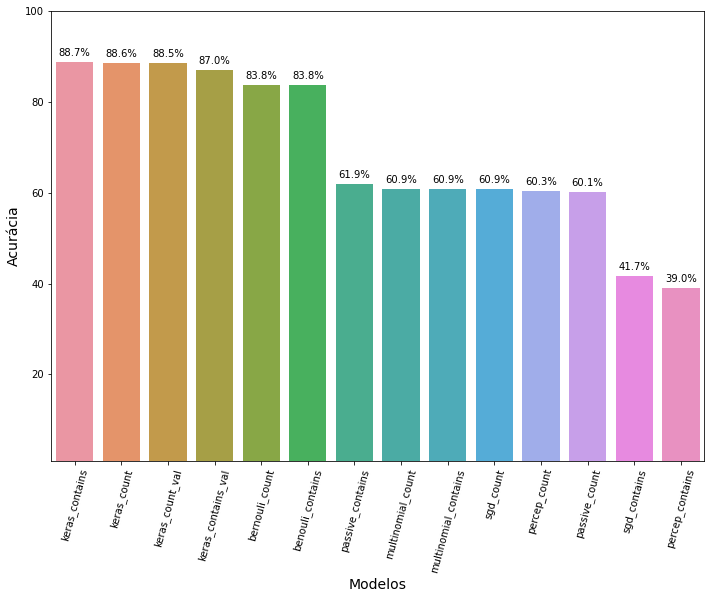

In [28]:
plt.xticks(rotation=75)
g = sns.barplot(x='model', y = 'accuracy', data=stats_df.sort_values(['accuracy'], ascending=False))
for p in g.patches:
    g.annotate(str(format(p.get_height(), '.1f')) + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Modelos", size=14)
plt.ylabel("Acurácia", size=14)
plt.savefig("acurácia modelos.png")
plt.gcf().set_size_inches(11.7, 8.27)
plt.ylim(1,100)
plt.show()

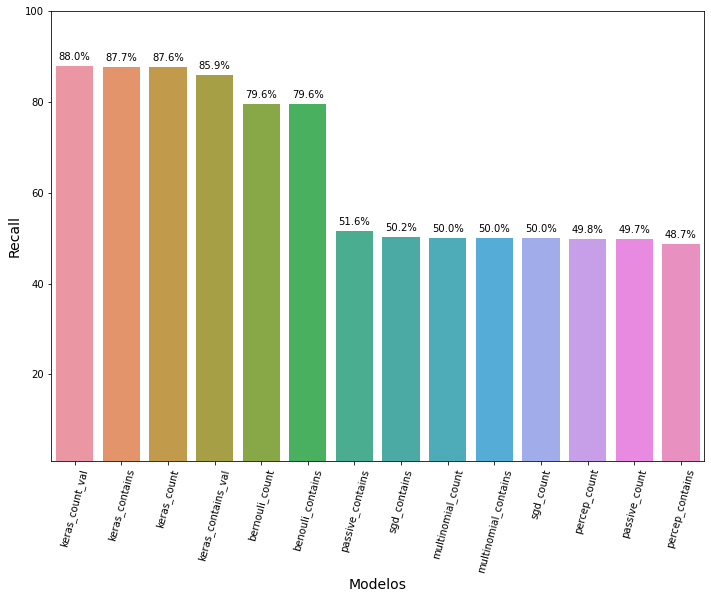

In [27]:
plt.xticks(rotation=75)
g = sns.barplot(x='model', y = 'recall', data=stats_df.sort_values(['recall'], ascending=False))
for p in g.patches:
    g.annotate(str(format(p.get_height(), '.1f')) + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Modelos", size=14)
plt.ylabel("Recall", size=14)
plt.savefig("acurácia modelos.png")
plt.gcf().set_size_inches(11.7, 8.27)
plt.ylim(1,100)
plt.show()

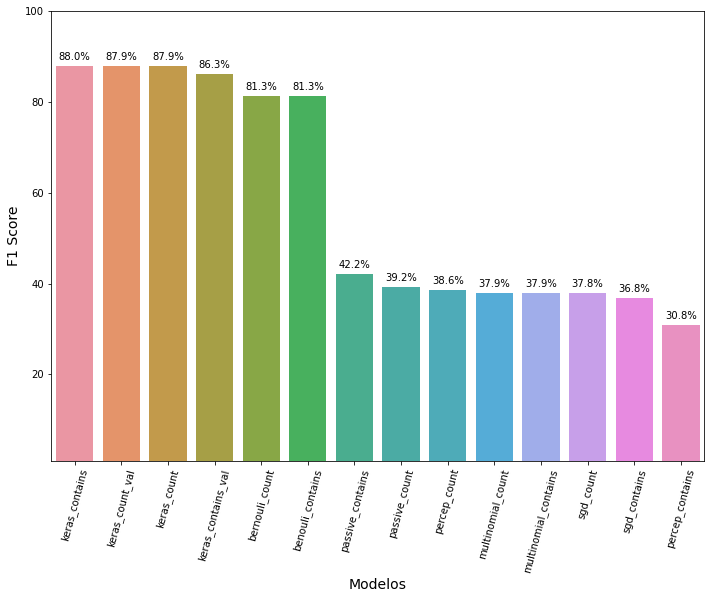

In [26]:
plt.xticks(rotation=75)
g = sns.barplot(x='model', y = 'f1_score', data=stats_df.sort_values(['f1_score'], ascending=False))
for p in g.patches:
    g.annotate(str(format(p.get_height(), '.1f')) + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Modelos", size=14)
plt.ylabel("F1 Score", size=14)
plt.savefig("acurácia modelos.png")
plt.gcf().set_size_inches(11.7, 8.27)
plt.ylim(1,100)
plt.show()

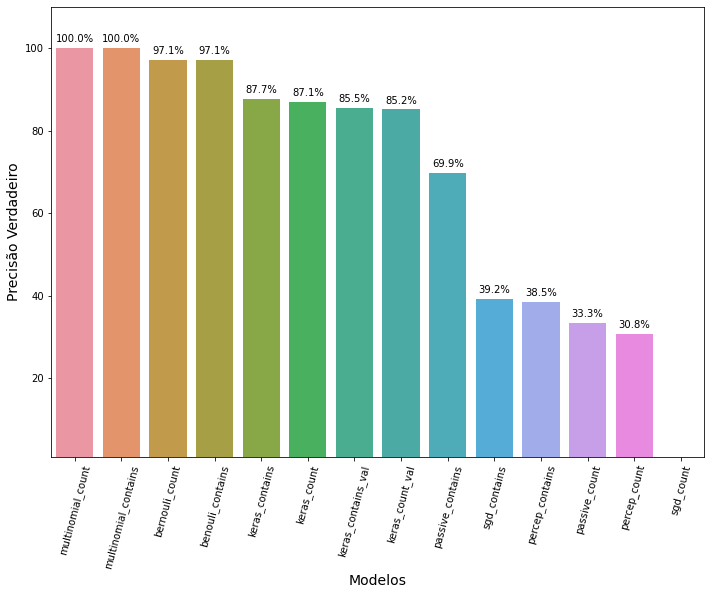

In [23]:
plt.xticks(rotation=75)
g = sns.barplot(x='model', y = 'verdadeiro_precision', data=stats_df.sort_values(['verdadeiro_precision'], ascending=False))
for p in g.patches:
    g.annotate(str(format(p.get_height(), '.1f')) + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Modelos", size=14)
plt.ylabel("Precisão Verdadeiro", size=14)
plt.savefig("acurácia modelos.png")
plt.gcf().set_size_inches(11.7, 8.27)
plt.ylim(1,110)
plt.show()

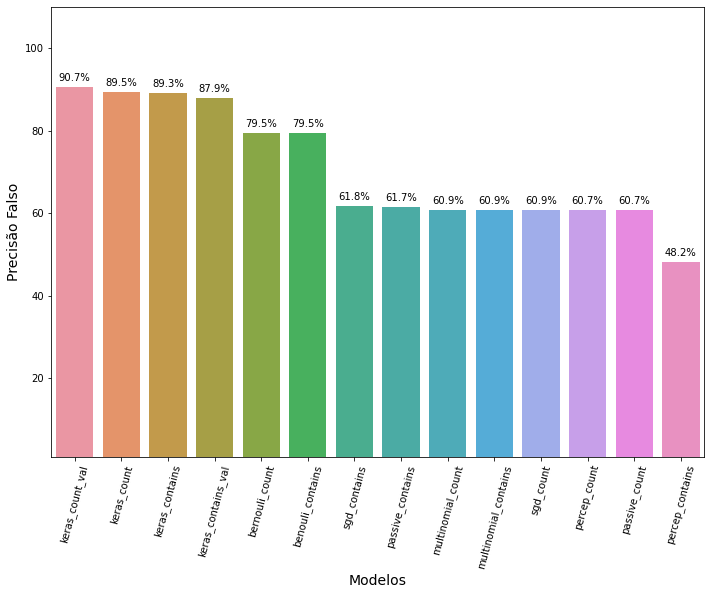

In [25]:
plt.xticks(rotation=75)
g = sns.barplot(x='model', y = 'falso_precision', data=stats_df.sort_values(['falso_precision'], ascending=False))
for p in g.patches:
    g.annotate(str(format(p.get_height(), '.1f')) + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Modelos", size=14)
plt.ylabel("Precisão Falso", size=14)
plt.savefig("Precisão Falso.png")
plt.gcf().set_size_inches(11.7, 8.27)
plt.ylim(1,110)
plt.show()

In [ ]:
		verdadeiro_recall	

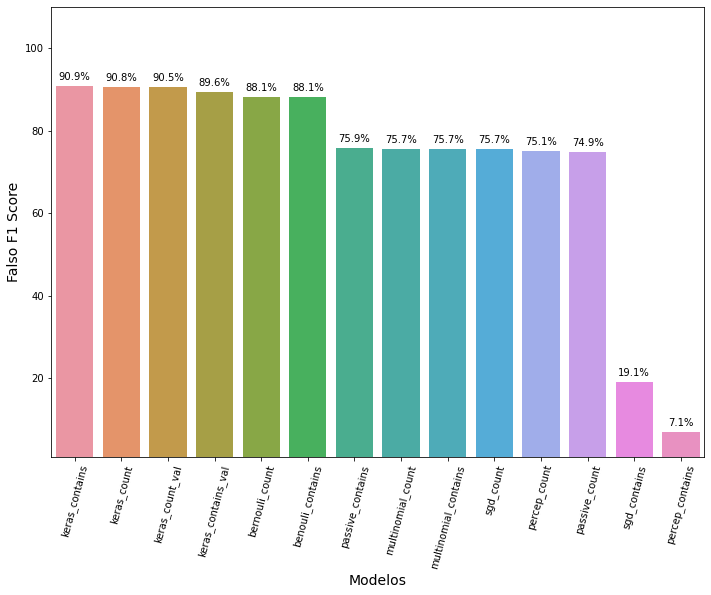

In [29]:
plt.xticks(rotation=75)
g = sns.barplot(x='model', y = 'falso_f1_score', data=stats_df.sort_values(['falso_f1_score'], ascending=False))
for p in g.patches:
    g.annotate(str(format(p.get_height(), '.1f')) + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Modelos", size=14)
plt.ylabel("Falso F1 Score", size=14)
plt.savefig("Precisão Falso.png")
plt.gcf().set_size_inches(11.7, 8.27)
plt.ylim(1,110)
plt.show()

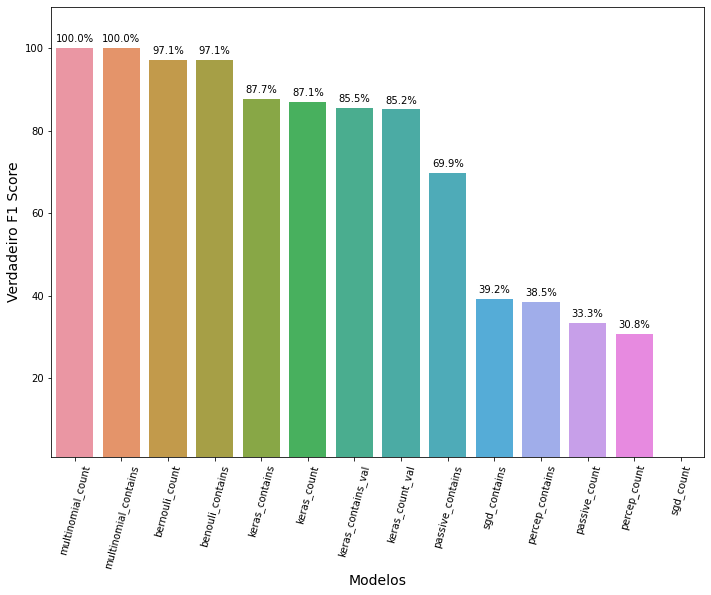

In [31]:
plt.xticks(rotation=75)
g = sns.barplot(x='model', y = 'verdadeiro_precision', data=stats_df.sort_values(['verdadeiro_precision'], ascending=False))
for p in g.patches:
    g.annotate(str(format(p.get_height(), '.1f')) + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Modelos", size=14)
plt.ylabel("Verdadeiro F1 Score", size=14)
plt.savefig("Precisão Falso.png")
plt.gcf().set_size_inches(11.7, 8.27)
plt.ylim(1,110)
plt.show()

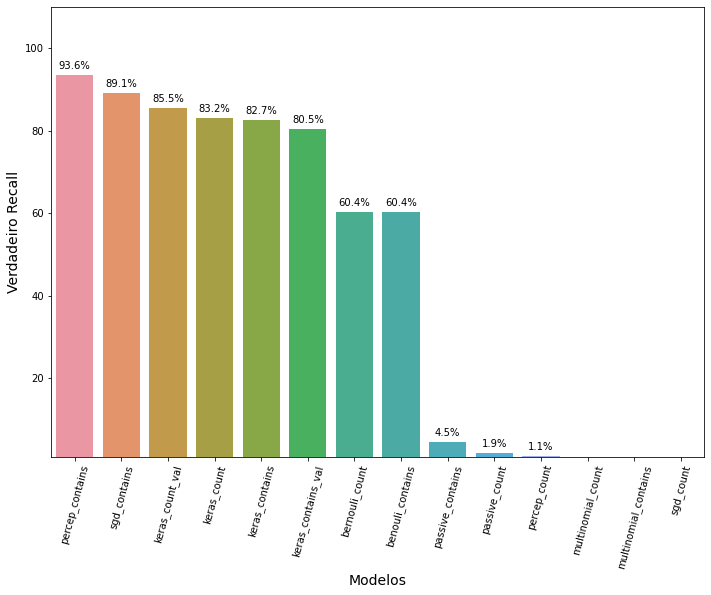

In [34]:
plt.xticks(rotation=75)
g = sns.barplot(x='model', y = 'verdadeiro_recall', data=stats_df.sort_values(['verdadeiro_recall'], ascending=False))
for p in g.patches:
    g.annotate(str(format(p.get_height(), '.1f')) + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Modelos", size=14)
plt.ylabel("Verdadeiro Recall", size=14)
plt.savefig("Verdadeiro Recall.png")
plt.gcf().set_size_inches(11.7, 8.27)
plt.ylim(1,110)
plt.show()

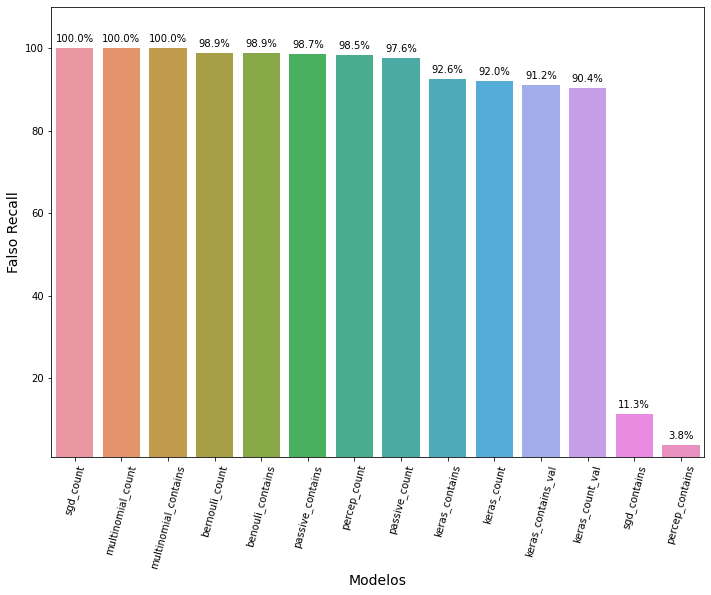

In [36]:
plt.xticks(rotation=75)
g = sns.barplot(x='model', y = 'falso_recall', data=stats_df.sort_values(['falso_recall'], ascending=False))
for p in g.patches:
    g.annotate(str(format(p.get_height(), '.1f')) + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Modelos", size=14)
plt.ylabel("Falso Recall", size=14)
plt.savefig("Falso Recall.png")
plt.gcf().set_size_inches(11.7, 8.27)
plt.ylim(1,110)
plt.show()